# Packages & Functions

In [2]:
import numpy as np
import xarray as xr
import pandas as pd

import scipy.cluster.hierarchy as sch
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import squareform
from scipy import stats
from scipy.signal import boxcar, convolve, correlate

from bs4 import BeautifulSoup
from zipfile import ZipFile
from shapely.geometry import LineString, MultiLineString, Point
from shapely.ops import nearest_points

import pickle

import glob
import warnings
import time
import sys
import psutil
from ast import literal_eval

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import BoundaryNorm
plt.rcParams['figure.figsize'] = [9, 9]
plt.rcParams['figure.dpi'] = 300

In [3]:
def using_clump(a):
    return [a[s] for s in np.ma.clump_unmasked(np.ma.masked_invalid(a))]

def using_clump_withtime(a,b):
    return [a[s] for s in np.ma.clump_unmasked(np.ma.masked_invalid(a))],[b[s] for s in np.ma.clump_unmasked(np.ma.masked_invalid(a))]

In [4]:
def autocorrelation_dayweek(x):
    #for hourly data
    #timeseries is repeated in calculation to avoid artificial zero-pad decay
    #returns correlation of timeseries x 1-day out and 1-week out
    c = signal.correlate((np.hstack((x,x))-np.mean(x))/np.std(x),(np.hstack((x,x))-np.mean(x))/np.std(x),mode='same',method='fft')/len(x)/2
    return c[int(len(c)/2)+1*24],c[int(len(c)/2)+7*24]

def autocorrelation_minweek(x):
    #for hourly data
    #timeseries is repeated in calculation to avoid artificial zero-pad decay
    #returns day out of weakest correlation within 1-week and the value there
    c = signal.correlate((np.hstack((x,x))-np.mean(x))/np.std(x),(np.hstack((x,x))-np.mean(x))/np.std(x),mode='same',method='fft')/len(x)/2
    return np.argmin(c[int(len(c)/2):int(len(c)/2)+7*24:24]),np.min(c[int(len(c)/2):int(len(c)/2)+7*24:24])

In [5]:
def get_r(x):
    temp = x.reshape(np.shape(x)[0],np.shape(x)[1]*np.shape(x)[2])
    temp = temp-np.mean(temp,0)
    chunksize = 268 # this is a factor specific to the number of tiles in this study
    nchunks = int(np.shape(temp)[1]/chunksize)
    r = np.empty((np.shape(temp)[1],np.shape(temp)[1]))
    for i in range(nchunks):
        temp0 = temp[:,chunksize*i:chunksize*(i+1)]
        temp0 = np.repeat(temp0[:,:,np.newaxis],np.shape(temp)[1],axis=2)
        temp1 = np.repeat(temp[:,:,np.newaxis],np.shape(temp0)[1],axis=2)
        r[chunksize*i:chunksize*(i+1)] = np.sum(temp0*np.transpose(temp1,(0,2,1)),axis=0)/(np.sum(temp0**2,axis=0)*np.sum(np.transpose(temp1,(0,2,1))**2,axis=0))**0.5
    return r

In [6]:
def windpower(wind):
    rhof = 1.2
    bladelength = 150/2
    A = np.pi*bladelength**2
    betzC = 16/27
    wefficiency = 0.65
    powerlimit = 5e+6
    scalefactor = rhof*A*betzC*wefficiency/2/powerlimit

    windlimit  = 25
    windcutinspeed = 0

    beta = 5

    f = (wind-windcutinspeed)**3*scalefactor
    g = np.ones_like(wind)
    windpower = (f**-beta+g**-beta)**(-1/beta)
    windpower = windpower.where(wind<windlimit,0)
    windpower = windpower.fillna(0)

    return windpower

In [7]:
def factors(n):
    return np.asarray([x for tup in ([i, n//i] 
                for i in range(1, int(n**0.5)+1) if n % i == 0) for x in tup])
def get_chunksize(x):
    return np.max(factors(np.shape(x)[1])[factors(np.shape(x)[1])<int(np.floor(psutil.virtual_memory()[1]/(8*np.prod(np.shape(x)))/4))])

def get_rflat(x,verbose='False',getchunks='True'):
    r         = np.empty((np.shape(x)[1],np.shape(x)[1]))
    x         = x-np.mean(x,0)
    if getchunks:
        chunksize = get_chunksize(x)
    else:
        chunksize = 2
    nchunks   = int(np.shape(x)[1]/chunksize) 
    t0        = time.time()
    if verbose:
        print('chunksize = %d, nchunks = %d'%(chunksize,nchunks),
                  end='\r')
    for i in range(nchunks):
        temp0 = x[:,chunksize*i:chunksize*(i+1)]
        temp0 = np.repeat(temp0[:,:,np.newaxis],np.shape(x)[1],axis=2)
        temp1 = np.repeat(x[:,:,np.newaxis],np.shape(temp0)[1],axis=2)
        r[chunksize*i:chunksize*(i+1)] = np.sum(temp0*np.transpose(temp1,(0,2,1)),axis=0)/(np.sum(temp0**2,axis=0)*np.sum(np.transpose(temp1,(0,2,1))**2,axis=0))**0.5
        if verbose:
            print('%03d%% complete, elapsed time %.2e s, estimated time remaining %.2e s'%((100*(i+1)/nchunks),
                                                                                           (time.time()-t0),
                                                                                           ((time.time()-t0)*(nchunks/(i+1)-1))),
                  end='\r')
    return r

# Constants

In [8]:
directory = '/g/data/k10/ag5517/aus-renewables-0923/'

# aus
lonlims = [112.5,154]
latlims = [-44,-10.5]

years  = np.arange(1979,2021+1)
months = np.arange(1,12+1)

approxbaseload = 25*1e+9

In [9]:
lsmthr = 0.8
lsmdf = xr.open_dataset('/g/data/rt52/era5/single-levels/monthly-averaged-by-hour/lsm/1999/lsm_era5_mnth_sfc_19990101-19990131.nc')
lsmdf = lsmdf.where((lsmdf.longitude>lonlims[0])&(lsmdf.longitude<=lonlims[1])&(lsmdf.latitude>latlims[0])&(lsmdf.latitude<=latlims[1]),drop=True)
dlon = np.diff(lsmdf.longitude)[0]
dlat = np.diff(lsmdf.latitude)[0]
r = 6371.229*1e+3
tlon = np.linspace(lsmdf.longitude[0]-dlon/2,lsmdf.longitude[-1]+dlon/2,len(lsmdf.longitude)+1)
tlat = np.linspace(lsmdf.latitude[0]-dlat/2,lsmdf.latitude[-1]+dlat/2,len(lsmdf.latitude)+1)
Lon,Lat = np.meshgrid(tlon,tlat)
Ly = (r*np.diff(Lat*np.pi/180,axis=0))[:,1:]
Lx = (r*np.diff(Lon*np.pi/180,axis=1)*np.sin(np.pi/2-Lat[:,1:]*np.pi/180))[1:]
As = np.abs(Lx*Ly)
lsm = np.asarray(lsmdf.lsm[0])
lsm[lsm<lsmthr] = np.nan
lsm = lsm/lsm
lsm[0,150] = np.nan

In [10]:
temp0 = np.copy(lsm)
temp0[np.isnan(temp0)] = 0
temp1 = np.zeros_like(temp0)
temp3 = np.zeros_like(temp0)
for j in range(1,len(lsmdf.longitude)-1):
    for i in range(1,len(lsmdf.latitude)-1):
        if temp0[i,j]==0:
            if temp0[i,j+1]==1 or temp0[i,j-1]==1 or temp0[i+1,j]==1 or temp0[i-1,j]==1:
                temp1[i,j]=1
temp2 = temp0+temp1
for j in range(1,len(lsmdf.longitude)-1):
    for i in range(1,len(lsmdf.latitude)-1):
        if temp2[i,j]==0:
            if temp2[i,j+1]==1 or temp2[i,j-1]==1 or temp2[i+1,j]==1 or temp2[i-1,j]==1:
                temp3[i,j]=1
lsmc = temp2+temp3
lsmc[lsmc==0] = np.nan
lsmc = lsmc/lsmc

lsmcindsflat = np.arange(len(np.ndarray.flatten(lsmc)))*np.ndarray.flatten(lsmc)
lsmcinds = lsmcindsflat.reshape(np.shape(lsmc)[0],np.shape(lsmc)[1])

lsmcindslsmc = np.empty((np.shape(lsmc)[0],np.shape(lsmc)[1]))*np.nan
counter = 0
for i in range(np.shape(lsmc)[0]):
    for j in range(np.shape(lsmc)[1]):
        if lsmc[i,j]==1:
            lsmcindslsmc[i,j] = counter
            counter += 1
            
coastm = np.copy(lsmc)
coastm[lsm==1] = np.nan

# Generate

In [11]:
smin = 10 #W/m^2

timeelapsed = np.empty(len(years)*len(months))
timecounter = 0
for i in range(len(years)):
    for j in range(len(months)):
        t0 = time.time()
        
        era5         = xr.open_dataset(glob.glob('/g/data/rt52/era5/single-levels/reanalysis/100u/%d/100u_era5_oper_sfc_%d%02d*.nc'%(years[i],years[i],months[j]))[0])
        era5         = era5.where((era5.longitude>lonlims[0])&(era5.longitude<=lonlims[1])&(era5.latitude>latlims[0])&(era5.latitude<=latlims[1]),drop=True)
        era5v100     = xr.open_dataset(glob.glob('/g/data/rt52/era5/single-levels/reanalysis/100v/%d/100v_era5_oper_sfc_%d%02d*.nc'%(years[i],years[i],months[j]))[0])
        era5v100     = era5v100.where((era5.longitude>lonlims[0])&(era5.longitude<=lonlims[1])&(era5.latitude>latlims[0])&(era5.latitude<=latlims[1]),drop=True)
        era5         = era5.merge(era5v100)
        era5msdwswrf = xr.open_dataset(glob.glob('/g/data/rt52/era5/single-levels/reanalysis/msdwswrf/%d/msdwswrf_era5_oper_sfc_%d%02d*.nc'%(years[i],years[i],months[j]))[0])
        era5msdwswrf = era5msdwswrf.where((era5.longitude>lonlims[0])&(era5.longitude<=lonlims[1])&(era5.latitude>latlims[0])&(era5.latitude<=latlims[1]),drop=True)
        era5         = era5.merge(era5msdwswrf)
        era5         = era5.assign(w=windpower((era5.u100**2+era5.v100**2)**0.5))
        
        wmaavg = np.asarray(era5.groupby('time.day').mean('time').w)
        wmamin = np.asarray(era5.groupby('time.day').min('time').w)
        wmnavg = np.asarray(era5.where(era5.msdwswrf<smin).groupby('time.day').mean('time').w)
        wmnmin = np.asarray(era5.where(era5.msdwswrf<smin).groupby('time.day').min('time').w)

        with open(directory+'era5-analysis-bymonth/%04d_%02d_analysis.pkl'%(years[i],months[j]),'wb') as f:
            pickle.dump((wmaavg,wmamin,wmnavg,wmnmin),f)
            
        timeelapsed[timecounter] = time.time()-t0
        print('year %04d, month %02d, time taken %.2e s, time elapsed %.2e s'%(years[i],
                                                                               months[j],
                                                                               timeelapsed[timecounter],
                                                                               np.sum(timeelapsed[:timecounter+1])),end='\r')
        timecounter += 1

In [11]:
Wmnavg = [[] for i in range(len(years)*len(months))]

counter = 0
for i in range(len(years)):
    for j in range(len(months)):
        with open(directory+'era5-analysis-bymonth/%04d_%02d_analysis.pkl'%(years[i],months[j]),'rb') as f:
            (wmaavg,wmamin,Wmnavg[counter],wmnmin) = pickle.load(f)
        print('year %04d, month %02d'%(years[i],months[j]),end='\r')
        counter += 1

Wmnavg = np.concatenate(Wmnavg,0)
Wmnavglsmcflat = Wmnavg.reshape(np.shape(Wmnavg)[0],np.shape(Wmnavg)[1]*np.shape(Wmnavg)[2])[:,~np.isnan(lsmcindsflat)]
rlsmcWmnavg  = get_rflat(Wmnavglsmcflat,True,False)
with open(directory+'rlsmcWmnavg.pkl','wb') as f:
    pickle.dump(rlsmcWmnavg,f)

In [ ]:
for i in range(len(years)):
    counter = 0
    Wmnavg = [[] for i in range(len(months))]
    for j in range(len(months)):
        with open(directory+'era5-analysis-bymonth/%04d_%02d_analysis.pkl'%(years[i],months[j]),'rb') as f:
            (wmaavg,wmamin,Wmnavg[counter],wmnmin) = pickle.load(f)
        print('year %04d, month %02d'%(years[i],months[j]),end='\r')
        counter += 1
    Wmnavg = np.concatenate(Wmnavg,0)
    Wmnavglsmcflat = Wmnavg.reshape(np.shape(Wmnavg)[0],np.shape(Wmnavg)[1]*np.shape(Wmnavg)[2])[:,~np.isnan(lsmcindsflat)]
    rlsmcWmnavg = get_rflat(Wmnavglsmcflat,True,True)
    with open(directory+'rlsmcWmnavg-byyear/%04d_rlsmcWmnavg.pkl'%(years[i]),'wb') as f:
        pickle.dump(rlsmcWmnavg,f)

In [11]:
farms           = pd.read_csv(directory+'facilities.csv')
farmcapacity    = np.asarray(farms['Generator Capacity (MW)'])*1e+6
nwindfarms      = len(farms)
farmslatlon     = np.vstack((np.asarray(farms['Latitude']),np.asarray(farms['Longitude']))).T

plannedfarms           = pd.read_excel(directory+'wind-data-main.xlsx')
plannedfarms           = plannedfarms[plannedfarms['Development Status']!='Operating']
plannedfarmcapacity    = np.asarray(plannedfarms['Capacity, MW_ac'])*1e+6
nplannedwindfarms      = len(plannedfarms)
plannedfarmslatlon     = np.vstack((np.asarray(plannedfarms['Latitude']),np.asarray(plannedfarms['Longitude']))).T

# https://www.energy.gov.au/data/australian-electricity-generation-fuel-mix

In [12]:
templon,templat = np.meshgrid(np.asarray(lsmdf.longitude),np.asarray(lsmdf.latitude))
farmslatloninds = np.empty((nwindfarms,2)).astype(int)
for i in range(nwindfarms):
    tempr = ((templat-farmslatlon[i,0])**2+(templon-farmslatlon[i,1])**2)**0.5
    farmslatloninds[i,0],farmslatloninds[i,1] = np.where(tempr==np.nanmin(tempr*lsmc))
    
farmsm = np.empty((len(lsmdf.latitude),len(lsmdf.longitude)))*np.nan
for i in range(nwindfarms):
    farmsm[farmslatloninds[i,0],farmslatloninds[i,1]] = 1
    
farmslsmcflatinds = np.empty(nwindfarms).astype(int)
for i in range(nwindfarms):
    farmslsmcflatinds[i] = lsmcindslsmc[farmslatloninds[i,0],farmslatloninds[i,1]]
    
    
templon,templat = np.meshgrid(np.asarray(lsmdf.longitude),np.asarray(lsmdf.latitude))
plannedfarmslatloninds = np.empty((nplannedwindfarms,2)).astype(int)
for i in range(nplannedwindfarms):
    tempr = ((templat-plannedfarmslatlon[i,0])**2+(templon-plannedfarmslatlon[i,1])**2)**0.5
    plannedfarmslatloninds[i,0],plannedfarmslatloninds[i,1] = np.where(tempr==np.nanmin(tempr*lsmc))
    
plannedfarmsm = np.empty((len(lsmdf.latitude),len(lsmdf.longitude)))*np.nan
for i in range(nplannedwindfarms):
    plannedfarmsm[plannedfarmslatloninds[i,0],plannedfarmslatloninds[i,1]] = 1
    
plannedfarmslsmcflatinds = np.empty(nplannedwindfarms).astype(int)
for i in range(nplannedwindfarms):
    plannedfarmslsmcflatinds[i] = lsmcindslsmc[plannedfarmslatloninds[i,0],plannedfarmslatloninds[i,1]]

In [13]:
hypthfarmcapacity = np.asarray([250e+6,500e+6,750e+6])
nhypthfarms_s1 = np.round(np.sum(farmcapacity)/hypthfarmcapacity).astype(int)
nhypthfarms_s2 = np.round((np.sum(farmcapacity)+np.sum(plannedfarmcapacity))/hypthfarmcapacity).astype(int)

In [14]:
# https://data.gov.au/dataset/ds-ga-1185c97c-c042-be90-e053-12a3070a969b/details?q=national

with ZipFile(directory+'ElectricityTransmissionLines_v2_AG.kmz', 'r') as kmz:
    kml = kmz.open(kmz.filelist[0].filename, 'r').read()
soup = BeautifulSoup(kml, 'xml')

linestrings = soup.find_all('LineString')
linelatlons1 = [[] for i in range(len(linestrings))]

for i in range(len(linestrings)):
    linelatlon1 = []
    coordstrs = str(linestrings[i].find('coordinates')).split('\t')[5].split('\n')[0].split(' ')[:-1]
    for coordstr in coordstrs:
        linelatlon1.append(np.flip(np.asarray(coordstr.split(',0')[0].split(',')).astype(float)))
    linelatlons1[i] = np.asarray(linelatlon1)

linestrings = [[] for i in range(len(linestrings))]
for i in range(len(linestrings)):
    linestrings[i] = LineString(linelatlons1[i])
multilinestring1 = MultiLineString(linestrings)

In [15]:
y1_s1 = -45
y2_s1 =   2
x1_s1 = 127
x2_s1 = 155
y1_s2 = -28

linelatlons_s3 = []
linelatlons_s4 = []
for l in linelatlons1:
    if ((y2_s1-y1_s1)/(x2_s1-x1_s1)*(l[:,1]-x1_s1)+y1_s1>l[:,0]).any():
        linelatlons_s3.append(l)
    if ((y2_s1-y1_s1)/(x2_s1-x1_s1)*(l[:,1]-x1_s1)+y1_s1>l[:,0]).any() or (l[:,0]<y1_s2).all():
        linelatlons_s4.append(l)
        
linestrings_s3 = [[] for i in range(len(linelatlons_s3))]
for i in range(len(linestrings_s3)):
    linestrings_s3[i] = LineString(linelatlons_s3[i])
multilinestring_s3 = MultiLineString(linestrings_s3)
linestrings_s4 = [[] for i in range(len(linelatlons_s4))]
for i in range(len(linestrings_s4)):
    linestrings_s4[i] = LineString(linelatlons_s4[i])
multilinestring_s4 = MultiLineString(linestrings_s4)

In [16]:
maxdist_togrid = 100e+3

templon = np.asarray(lsmdf.longitude)
templat = np.asarray(lsmdf.latitude)

lsmc_s3 = np.zeros((len(templat),len(templon)))
for i in range(len(multilinestring_s3.geoms)):
    templatlon = multilinestring_s3.geoms[i].centroid.coords[0]
    temppoly   = multilinestring_s3.geoms[i].buffer(maxdist_togrid/As[np.argmin(np.abs(templat-templatlon[0])),np.argmin(np.abs(templon-templatlon[1]))]**0.5*np.diff(templon)[0])
    temploninds = np.ndarray.flatten(np.argwhere((templon<=temppoly.bounds[3])&(templon>=temppoly.bounds[1])))
    templatinds = np.ndarray.flatten(np.argwhere((templat<=temppoly.bounds[2])&(templat>=temppoly.bounds[0])))
    for j in templatinds:
        for k in temploninds:
            if temppoly.contains(Point((templat[j], templon[k]))):
                lsmc_s3[j,k] += 1
lsmc_s4 = np.zeros((len(templat),len(templon)))
for i in range(len(multilinestring_s4.geoms)):
    templatlon = multilinestring_s4.geoms[i].centroid.coords[0]
    temppoly   = multilinestring_s4.geoms[i].buffer(maxdist_togrid/As[np.argmin(np.abs(templat-templatlon[0])),np.argmin(np.abs(templon-templatlon[1]))]**0.5*np.diff(templon)[0])
    temploninds = np.ndarray.flatten(np.argwhere((templon<=temppoly.bounds[3])&(templon>=temppoly.bounds[1])))
    templatinds = np.ndarray.flatten(np.argwhere((templat<=temppoly.bounds[2])&(templat>=temppoly.bounds[0])))
    for j in templatinds:
        for k in temploninds:
            if temppoly.contains(Point((templat[j], templon[k]))):
                lsmc_s4[j,k] += 1

lsmcs3 = lsmc_s3/lsmc_s3*lsmc
lsmcs4 = lsmc_s4/lsmc_s4*lsmc

lsmcs3flatinds = np.empty(len(lsmcs3[~np.isnan(lsmcs3)])).astype(int)
for i in range(len(lsmcs3[~np.isnan(lsmcs3)])):
    lsmcs3flatinds[i] = lsmcindslsmc[np.argwhere(lsmcs3==1)[i,0],np.argwhere(lsmcs3==1)[i,1]]
lsmcs4flatinds = np.empty(len(lsmcs4[~np.isnan(lsmcs4)])).astype(int)
for i in range(len(lsmcs4[~np.isnan(lsmcs4)])):
    lsmcs4flatinds[i] = lsmcindslsmc[np.argwhere(lsmcs4==1)[i,0],np.argwhere(lsmcs4==1)[i,1]]

/jobfs/95717059.gadi-pbs/ipykernel_1959009/2402508011.py:27: RuntimeWarning: invalid value encountered in divide
  lsmcs3 = lsmc_s3/lsmc_s3*lsmc
/jobfs/95717059.gadi-pbs/ipykernel_1959009/2402508011.py:28: RuntimeWarning: invalid value encountered in divide
  lsmcs4 = lsmc_s4/lsmc_s4*lsmc


In [17]:
Wmaavg = [[] for i in range(len(years)*len(months))]
Wmnavg = [[] for i in range(len(years)*len(months))]
counter = 0
for i in range(len(years)):
    for j in range(len(months)):
        with open(directory+'era5-analysis-bymonth/%04d_%02d_analysis.pkl'%(years[i],months[j]),'rb') as f:
            (Wmaavg[counter],wmamin,Wmnavg[counter],wmnmin) = pickle.load(f)
        print('year %04d, month %02d'%(years[i],months[j]),end='\r')
        counter += 1
Wmaavg = np.concatenate(Wmaavg,0)
Wmaavglsmcflat = Wmaavg.reshape(np.shape(Wmaavg)[0],np.shape(Wmaavg)[1]*np.shape(Wmaavg)[2])[:,~np.isnan(lsmcindsflat)]
Wmnavg = np.concatenate(Wmnavg,0)
Wmnavglsmcflat = Wmnavg.reshape(np.shape(Wmnavg)[0],np.shape(Wmnavg)[1]*np.shape(Wmnavg)[2])[:,~np.isnan(lsmcindsflat)]

In [18]:
with open(directory+'rlsmcWmnavg.pkl','rb') as f:
    rlsmcs5Wmnavg = pickle.load(f)

In [19]:
Wmnavglsmcs5flat = Wmnavglsmcflat
Wmnavglsmcs3flat = Wmnavglsmcflat[:,lsmcs3flatinds]
Wmnavglsmcs4flat = Wmnavglsmcflat[:,lsmcs4flatinds]

Wmaavglsmcs5flat = Wmaavglsmcflat
Wmaavglsmcs3flat = Wmaavglsmcflat[:,lsmcs3flatinds]
Wmaavglsmcs4flat = Wmaavglsmcflat[:,lsmcs4flatinds]

rlsmcs3Wmnavg = rlsmcs5Wmnavg[lsmcs3flatinds][:,lsmcs3flatinds]
rlsmcs4Wmnavg = rlsmcs5Wmnavg[lsmcs4flatinds][:,lsmcs4flatinds]

In [20]:
rrlsmcWmnavg = np.empty((np.shape(lsmc)[0]*np.shape(lsmc)[1],np.shape(lsmc)[0]*np.shape(lsmc)[1]))*np.nan
for i in range(len(lsmcindsflat[~np.isnan(lsmcindsflat)].astype(int))):
    rrlsmcWmnavg[lsmcindsflat[~np.isnan(lsmcindsflat)].astype(int)[i],lsmcindsflat[~np.isnan(lsmcindsflat)].astype(int)] = rlsmcs5Wmnavg[i]
rrlsmcWmnavg = rrlsmcWmnavg.reshape(np.shape(lsmc)[0],np.shape(lsmc)[1],np.shape(lsmc)[0],np.shape(lsmc)[1])

In [21]:
Wmnavgfarms = Wmnavglsmcflat[:,farmslsmcflatinds]
Wmnavgplannedfarms = Wmnavglsmcflat[:,plannedfarmslsmcflatinds]
powersums1 = np.sum(Wmnavgfarms*farmcapacity[None,:],1)
powersums2 = powersums1+np.sum(Wmnavgplannedfarms*plannedfarmcapacity[None,:],1)

In [30]:
pdist   = pairwise_distances(rlsmcs5Wmnavg)
linkage = sch.linkage(squareform(pdist.astype('float32')), method='complete')
    
ninds                = np.arange(1,np.max((nhypthfarms_s1,nhypthfarms_s2))+1)
lsmcflatindssorted   = np.empty((len(ninds),ninds[-1]))
lonlatindssorted     = np.empty((len(ninds),ninds[-1],2))
    
for j in range(len(ninds)):
    idxtemp          = sch.fcluster(linkage, ninds[j], 'maxclust')
    idxmaptemp       = np.empty((np.shape(lsmc)[0]*np.shape(lsmc)[1]))*np.nan
    inds             = np.ndarray.flatten(np.argwhere(np.ndarray.flatten(lsmc)==1))
    idxmaptemp[inds] = idxtemp
    idxmaptemp       = idxmaptemp.reshape(np.shape(lsmc)[0],np.shape(lsmc)[1])

    tempflat     = [np.argwhere(idxtemp==i)[np.argmax(np.mean(Wmnavglsmcflat,0)[idxtemp==i])][0] for i in range(1,ninds[j]+1)]
    templatlon   = np.vstack([np.argwhere(idxmaptemp==i)[np.argmax(np.mean(Wmnavglsmcflat,0)[idxtemp==i])] for i in range(1,ninds[j]+1)])
    tempr        = rlsmcs5Wmnavg[tempflat][:,tempflat]

    farminds    = np.argmin(np.abs(np.mean(tempr,0)))
    farmindsout = np.arange(ninds[j])
    farmindsout = farmindsout[farmindsout!=farminds]
    for k in range(1,ninds[j]):
        rtotal = np.ones(ninds[j])
        for i in farmindsout:
            inds = np.hstack((farminds,i))
            rtotal[i] = np.sum(tempr[inds][:,inds]-np.eye(len(tempr[inds][:,inds])))/(len(inds)**2-len(inds))
        farminds    = np.hstack((farminds,np.argmin(rtotal)))
        farmindsout = farmindsout[farmindsout!=np.argmin(rtotal)]

    lsmcflatindssorted[j,:ninds[j]]   = np.asarray(tempflat)[farminds]
    lonlatindssorted[j,:ninds[j]]     = templatlon[farminds]

    print('%02d out of %d done'%(j+1,len(ninds)),end='\r')

with open(directory+'varnumhypthfarmss5.pkl','wb') as f:
    pickle.dump((ninds,lsmcflatindssorted,lonlatindssorted),f)

In [31]:
pdist   = pairwise_distances(rlsmcs4Wmnavg)
linkage = sch.linkage(squareform(pdist.astype('float32')), method='complete')
    
ninds                = np.arange(1,np.max((nhypthfarms_s1,nhypthfarms_s2))+1)
lsmcflatindssorted   = np.empty((len(ninds),ninds[-1]))
lonlatindssorted     = np.empty((len(ninds),ninds[-1],2))
    
for j in range(len(ninds)):
    idxtemp          = sch.fcluster(linkage, ninds[j], 'maxclust')
    idxmaptemp       = np.empty((np.shape(lsmcs4)[0]*np.shape(lsmcs4)[1]))*np.nan
    inds             = np.ndarray.flatten(np.argwhere(np.ndarray.flatten(lsmcs4)==1))
    idxmaptemp[inds] = idxtemp
    idxmaptemp       = idxmaptemp.reshape(np.shape(lsmcs4)[0],np.shape(lsmcs4)[1])

    tempflat     = [np.argwhere(idxtemp==i)[np.argmax(np.mean(Wmnavglsmcs4flat,0)[idxtemp==i])][0] for i in range(1,ninds[j]+1)]
    templatlon   = np.vstack([np.argwhere(idxmaptemp==i)[np.argmax(np.mean(Wmnavglsmcs4flat,0)[idxtemp==i])] for i in range(1,ninds[j]+1)])
    tempr        = rlsmcs4Wmnavg[tempflat][:,tempflat]

    farminds    = np.argmin(np.abs(np.mean(tempr,0)))
    farmindsout = np.arange(ninds[j])
    farmindsout = farmindsout[farmindsout!=farminds]
    for k in range(1,ninds[j]):
        rtotal = np.ones(ninds[j])
        for i in farmindsout:
            inds = np.hstack((farminds,i))
            rtotal[i] = np.sum(tempr[inds][:,inds]-np.eye(len(tempr[inds][:,inds])))/(len(inds)**2-len(inds))
        farminds    = np.hstack((farminds,np.argmin(rtotal)))
        farmindsout = farmindsout[farmindsout!=np.argmin(rtotal)]

    lsmcflatindssorted[j,:ninds[j]]   = np.asarray(tempflat)[farminds]
    lonlatindssorted[j,:ninds[j]]     = templatlon[farminds]

    print('%02d out of %d done'%(j+1,len(ninds)),end='\r')

with open(directory+'varnumhypthfarmss4.pkl','wb') as f:
    pickle.dump((ninds,lsmcflatindssorted,lonlatindssorted),f)

In [32]:
pdist   = pairwise_distances(rlsmcs3Wmnavg)
linkage = sch.linkage(squareform(pdist.astype('float32')), method='complete')
    
ninds                = np.arange(1,np.max((nhypthfarms_s1,nhypthfarms_s2))+1)
lsmcflatindssorted   = np.empty((len(ninds),ninds[-1]))
lonlatindssorted     = np.empty((len(ninds),ninds[-1],2))
    
for j in range(len(ninds)):
    idxtemp          = sch.fcluster(linkage, ninds[j], 'maxclust')
    idxmaptemp       = np.empty((np.shape(lsmcs3)[0]*np.shape(lsmcs3)[1]))*np.nan
    inds             = np.ndarray.flatten(np.argwhere(np.ndarray.flatten(lsmcs3)==1))
    idxmaptemp[inds] = idxtemp
    idxmaptemp       = idxmaptemp.reshape(np.shape(lsmcs3)[0],np.shape(lsmcs3)[1])

    tempflat     = [np.argwhere(idxtemp==i)[np.argmax(np.mean(Wmnavglsmcs3flat,0)[idxtemp==i])][0] for i in range(1,ninds[j]+1)]
    templatlon   = np.vstack([np.argwhere(idxmaptemp==i)[np.argmax(np.mean(Wmnavglsmcs3flat,0)[idxtemp==i])] for i in range(1,ninds[j]+1)])
    tempr        = rlsmcs3Wmnavg[tempflat][:,tempflat]

    farminds    = np.argmin(np.abs(np.mean(tempr,0)))
    farmindsout = np.arange(ninds[j])
    farmindsout = farmindsout[farmindsout!=farminds]
    for k in range(1,ninds[j]):
        rtotal = np.ones(ninds[j])
        for i in farmindsout:
            inds = np.hstack((farminds,i))
            rtotal[i] = np.sum(tempr[inds][:,inds]-np.eye(len(tempr[inds][:,inds])))/(len(inds)**2-len(inds))
        farminds    = np.hstack((farminds,np.argmin(rtotal)))
        farmindsout = farmindsout[farmindsout!=np.argmin(rtotal)]

    lsmcflatindssorted[j,:ninds[j]]   = np.asarray(tempflat)[farminds]
    lonlatindssorted[j,:ninds[j]]     = templatlon[farminds]

    print('%02d out of %d done'%(j+1,len(ninds)),end='\r')

with open(directory+'varnumhypthfarmss3.pkl','wb') as f:
    pickle.dump((ninds,lsmcflatindssorted,lonlatindssorted),f)

In [22]:
with open(directory+'varnumhypthfarmss3.pkl','rb') as f:
    ninds,lsmcs3flatindssorted,lonlatindss3sorted = pickle.load(f)
with open(directory+'varnumhypthfarmss4.pkl','rb') as f:
    ninds,lsmcs4flatindssorted,lonlatindss4sorted = pickle.load(f)
with open(directory+'varnumhypthfarmss5.pkl','rb') as f:
    ninds,lsmcs5flatindssorted,lonlatindss5sorted = pickle.load(f)

In [23]:
powersums = np.empty((2,3,len(hypthfarmcapacity),len(Wmnavglsmcflat)))*np.nan
for k in range(len(hypthfarmcapacity)):
    tempinds = [np.argwhere(ninds==nhypthfarms_s1[i])[0][0] for i in range(len(nhypthfarms_s1))]
    powersums[0,0,k] = np.sum(Wmnavglsmcs3flat[:,lsmcs3flatindssorted[tempinds[k],:tempinds[k]+1].astype(int)]*hypthfarmcapacity[k],1)
    powersums[0,1,k] = np.sum(Wmnavglsmcs4flat[:,lsmcs4flatindssorted[tempinds[k],:tempinds[k]+1].astype(int)]*hypthfarmcapacity[k],1)
    powersums[0,2,k] = np.sum(Wmnavglsmcs5flat[:,lsmcs5flatindssorted[tempinds[k],:tempinds[k]+1].astype(int)]*hypthfarmcapacity[k],1)
    tempinds = [np.argwhere(ninds==nhypthfarms_s2[i])[0][0] for i in range(len(nhypthfarms_s2))]
    powersums[1,0,k] = np.sum(Wmnavglsmcs3flat[:,lsmcs3flatindssorted[tempinds[k],:tempinds[k]+1].astype(int)]*hypthfarmcapacity[k],1) 
    powersums[1,1,k] = np.sum(Wmnavglsmcs4flat[:,lsmcs4flatindssorted[tempinds[k],:tempinds[k]+1].astype(int)]*hypthfarmcapacity[k],1)
    powersums[1,2,k] = np.sum(Wmnavglsmcs5flat[:,lsmcs5flatindssorted[tempinds[k],:tempinds[k]+1].astype(int)]*hypthfarmcapacity[k],1)

In [24]:
rlsmcWmnavgplannedfarms = np.empty((nwindfarms+nplannedwindfarms,nwindfarms+nplannedwindfarms))
for i in range(nwindfarms):
    for j in range(nwindfarms):
        rlsmcWmnavgplannedfarms[i,j] = rrlsmcWmnavg[farmslatloninds[i,0],farmslatloninds[i,1]][farmslatloninds[j,0],farmslatloninds[j,1]]        
        
for i in range(nplannedwindfarms):
    for j in range(nplannedwindfarms):
        rlsmcWmnavgplannedfarms[nwindfarms+i,nwindfarms+j] = rrlsmcWmnavg[plannedfarmslatloninds[i,0],plannedfarmslatloninds[i,1]][plannedfarmslatloninds[j,0],plannedfarmslatloninds[j,1]]        
                
for i in range(nplannedwindfarms):
    for j in range(nwindfarms):
        rlsmcWmnavgplannedfarms[nwindfarms+i,j] = rrlsmcWmnavg[plannedfarmslatloninds[i,0],plannedfarmslatloninds[i,1]][farmslatloninds[j,0],farmslatloninds[j,1]]        
               
for i in range(nwindfarms):
    for j in range(nplannedwindfarms):
        rlsmcWmnavgplannedfarms[i,nwindfarms+j] = rrlsmcWmnavg[farmslatloninds[i,0],farmslatloninds[i,1]][plannedfarmslatloninds[j,0],plannedfarmslatloninds[j,1]]                   

In [25]:
chosenfarminds  = np.arange(nwindfarms)
plannedfarminds = np.arange(nplannedwindfarms)
for j in range(nplannedwindfarms):
    rtotal = np.ones(nplannedwindfarms)
    for i in plannedfarminds:
        inds = np.hstack((chosenfarminds,nwindfarms+i))
        rtotal[i] = np.sum(rlsmcWmnavgplannedfarms[inds][:,inds]-np.eye(len(rlsmcWmnavgplannedfarms[inds][:,inds])))/(len(inds)**2-len(inds))
    chosenfarminds  = np.hstack((chosenfarminds,nwindfarms+np.argmin(rtotal)))
    plannedfarminds = plannedfarminds[plannedfarminds!=np.argmin(rtotal)]

In [37]:
powertimeseries   = np.empty((2,3,3,376944))*np.nan
powertimeseriess1 = np.empty(376944)*np.nan
powertimeseriess2 = np.empty(376944)*np.nan

timeelapsed = np.empty(len(years)*len(months))
timecounter = 0
indcounter  = 0
for i in range(len(years)):
    for j in range(len(months)):
        t0 = time.time()

        era5         = xr.open_dataset(glob.glob('/g/data/rt52/era5/single-levels/reanalysis/100u/%d/100u_era5_oper_sfc_%d%02d*.nc'%(years[i],years[i],months[j]))[0])
        era5         = era5.where((era5.longitude>lonlims[0])&(era5.longitude<=lonlims[1])&(era5.latitude>latlims[0])&(era5.latitude<=latlims[1]),drop=True)
        era5v100     = xr.open_dataset(glob.glob('/g/data/rt52/era5/single-levels/reanalysis/100v/%d/100v_era5_oper_sfc_%d%02d*.nc'%(years[i],years[i],months[j]))[0])
        era5v100     = era5v100.where((era5.longitude>lonlims[0])&(era5.longitude<=lonlims[1])&(era5.latitude>latlims[0])&(era5.latitude<=latlims[1]),drop=True)
        era5         = era5.merge(era5v100)
        era5         = era5.assign(w=windpower((era5.u100**2+era5.v100**2)**0.5))
        tempw = np.asarray(era5.w)
        for k in range(len(hypthfarmcapacity)):
            tempinds = [np.argwhere(ninds==nhypthfarms_s1[l])[0][0] for l in range(len(nhypthfarms_s1))]
            powertimeseries[0,0,k,indcounter:indcounter+len(tempw)] = np.sum(tempw[:,
                                                                                   lonlatindss3sorted[tempinds[k],:tempinds[k]+1,0].astype(int),
                                                                                   lonlatindss3sorted[tempinds[k],:tempinds[k]+1,1].astype(int)]*hypthfarmcapacity[k],
                                                                             1)
            powertimeseries[0,1,k,indcounter:indcounter+len(tempw)] = np.sum(tempw[:,
                                                                                   lonlatindss4sorted[tempinds[k],:tempinds[k]+1,0].astype(int),
                                                                                   lonlatindss4sorted[tempinds[k],:tempinds[k]+1,1].astype(int)]*hypthfarmcapacity[k],
                                                                             1)
            powertimeseries[0,2,k,indcounter:indcounter+len(tempw)] = np.sum(tempw[:,
                                                                                   lonlatindss5sorted[tempinds[k],:tempinds[k]+1,0].astype(int),
                                                                                   lonlatindss5sorted[tempinds[k],:tempinds[k]+1,1].astype(int)]*hypthfarmcapacity[k],
                                                                             1)            
            tempinds = [np.argwhere(ninds==nhypthfarms_s2[l])[0][0] for l in range(len(nhypthfarms_s2))]
            powertimeseries[1,0,k,indcounter:indcounter+len(tempw)] = np.sum(tempw[:,
                                                                                   lonlatindss3sorted[tempinds[k],:tempinds[k]+1,0].astype(int),
                                                                                   lonlatindss3sorted[tempinds[k],:tempinds[k]+1,1].astype(int)]*hypthfarmcapacity[k],
                                                                             1)
            powertimeseries[1,1,k,indcounter:indcounter+len(tempw)] = np.sum(tempw[:,
                                                                                   lonlatindss4sorted[tempinds[k],:tempinds[k]+1,0].astype(int),
                                                                                   lonlatindss4sorted[tempinds[k],:tempinds[k]+1,1].astype(int)]*hypthfarmcapacity[k],
                                                                             1)
            powertimeseries[1,2,k,indcounter:indcounter+len(tempw)] = np.sum(tempw[:,
                                                                                   lonlatindss5sorted[tempinds[k],:tempinds[k]+1,0].astype(int),
                                                                                   lonlatindss5sorted[tempinds[k],:tempinds[k]+1,1].astype(int)]*hypthfarmcapacity[k],
                                                                             1)
        
        powertimeseriess1[indcounter:indcounter+len(tempw)] = np.sum(tempw[:,farmslatloninds[:,0],farmslatloninds[:,1]]*farmcapacity[None,:],1)
        powertimeseriess2[indcounter:indcounter+len(tempw)] = powertimeseriess1[indcounter:indcounter+len(tempw)] + np.sum(tempw[:,plannedfarmslatloninds[:,0],plannedfarmslatloninds[:,1]]*plannedfarmcapacity[None,:],1)
        
        indcounter += len(tempw)
        
        timeelapsed[timecounter] = time.time()-t0
        print('year %04d, month %02d, time taken %.2e s, time elapsed %.2e s'%(years[i],
                                                                               months[j],
                                                                               timeelapsed[timecounter],
                                                                               np.sum(timeelapsed[:timecounter+1])),end='\r')
        timecounter += 1
        
with open(directory+'scenario-power-timeseries.pkl','wb') as f:
    pickle.dump((powertimeseries,powertimeseriess1,powertimeseriess2),f)

In [26]:
with open(directory+'scenario-power-timeseries.pkl','rb') as f:
    (powertimeseries,powertimeseriess1,powertimeseriess2) = pickle.load(f)

In [27]:
tempthr   = np.logspace(-1.5,2.5,251)*1e+9

drought   = np.empty((np.shape(powertimeseries)[0],np.shape(powertimeseries)[1],np.shape(powertimeseries)[2],len(tempthr)))
droughts1 = np.empty(len(tempthr))
droughts2 = np.empty(len(tempthr))

for k in range(len(tempthr)):
    temp = np.copy(powertimeseriess1)
    temp[temp>tempthr[k]] = np.nan
    tempclump = using_clump(temp)
    try:
        droughts1[k] = np.max(np.asarray([len(tempclump[i]) for i in range(len(tempclump))]))
    except:
        droughts1[k] = 0
    temp = np.copy(powertimeseriess2)
    temp[temp>tempthr[k]] = np.nan
    tempclump = using_clump(temp)
    try:
        droughts2[k] = np.max(np.asarray([len(tempclump[i]) for i in range(len(tempclump))]))
    except:
        droughts2[k] = 0
    for j in range(np.shape(powertimeseries)[0]):
        for l in range(np.shape(powertimeseries)[1]):
            for m in range(np.shape(powertimeseries)[2]):
                temp = np.copy(powertimeseries[j,l,m])
                temp[temp>tempthr[k]] = np.nan
                tempclump = using_clump(temp)
                try:
                    drought[j,l,m,k] = np.max(np.asarray([len(tempclump[i]) for i in range(len(tempclump))]))
                except:
                    drought[j,l,m,k] = 0

In [ ]:
lonlatindsyear   = np.empty((len(years),nhypthfarms_s2[1],2))
lsmcflatindsyear = np.empty((len(years),nhypthfarms_s2[1]))

for i in range(len(years)):
    with open(directory+'rlsmcWmnavg-byyear/%04d_rlsmcWmnavg.pkl'%(years[i]),'rb') as f:
        rlsmcWmnavgyeari = pickle.load(f)
        
    pdist   = pairwise_distances(rlsmcWmnavgyeari)
    linkage = sch.linkage(squareform(pdist.astype('float32')), method='complete')

    idxtemp           = sch.fcluster(linkage, nhypthfarms_s2[1], 'maxclust')
    idxmaptemp        = np.empty((np.shape(lsmc)[0]*np.shape(lsmc)[1]))*np.nan
    inds              = np.ndarray.flatten(np.argwhere(np.ndarray.flatten(lsmc)==1))
    idxmaptemp[inds]  = idxtemp
    idxmaptemp        = idxmaptemp.reshape(np.shape(lsmc)[0],np.shape(lsmc)[1])
    
    lsmcflatindsyear[i] = np.asarray([np.argwhere(idxtemp==l)[np.argmax(np.mean(Wmnavglsmcflat,0)[idxtemp==l])][0] for l in range(1,nhypthfarms_s2[1]+1)])
    lonlatindsyear[i]   = np.vstack([np.argwhere(idxmaptemp==l)[np.argmax(np.mean(Wmnavglsmcflat,0)[idxtemp==l])] for l in range(1,nhypthfarms_s2[1]+1)])

    print('%02d out of %d done'%(i+1,len(years)),end='\r')

with open(directory+'locations-byyear.pkl','wb') as f:
    pickle.dump((lsmcflatindsyear,lonlatindsyear),f)

In [ ]:
powertimeseriess5s2c2byyear = np.empty((len(years),376944))*np.nan

timeelapsed = np.empty(len(years)*len(months))
timecounter = 0
indcounter  = 0
for i in range(len(years)):
    for j in range(len(months)):
        t0 = time.time()

        era5         = xr.open_dataset(glob.glob('/g/data/rt52/era5/single-levels/reanalysis/100u/%d/100u_era5_oper_sfc_%d%02d*.nc'%(years[i],years[i],months[j]))[0])
        era5         = era5.where((era5.longitude>lonlims[0])&(era5.longitude<=lonlims[1])&(era5.latitude>latlims[0])&(era5.latitude<=latlims[1]),drop=True)
        era5v100     = xr.open_dataset(glob.glob('/g/data/rt52/era5/single-levels/reanalysis/100v/%d/100v_era5_oper_sfc_%d%02d*.nc'%(years[i],years[i],months[j]))[0])
        era5v100     = era5v100.where((era5.longitude>lonlims[0])&(era5.longitude<=lonlims[1])&(era5.latitude>latlims[0])&(era5.latitude<=latlims[1]),drop=True)
        era5         = era5.merge(era5v100)
        era5         = era5.assign(w=windpower((era5.u100**2+era5.v100**2)**0.5))
        tempw = np.asarray(era5.w)
        for k in range(len(years)):
            powertimeseriess5s2c2byyear[k,indcounter:indcounter+len(tempw)] = np.sum(tempw[:,lonlatindsyear[k,:,0].astype(int),lonlatindsyear[k,:,1].astype(int)]*hypthfarmcapacity[1],1)
        indcounter += len(tempw)
        
        timeelapsed[timecounter] = time.time()-t0
        print('year %04d, month %02d, time taken %.2e s, time elapsed %.2e s'%(years[i],
                                                                               months[j],
                                                                               timeelapsed[timecounter],
                                                                               np.sum(timeelapsed[:timecounter+1])),end='\r')
        timecounter += 1
        
with open(directory+'scenario-power-timeseries-byyear.pkl','wb') as f:
    pickle.dump((powertimeseriess5s2c2byyear),f)

In [28]:
with open(directory+'scenario-power-timeseries-byyear.pkl','rb') as f:
    powertimeseriess5s2c2byyear = pickle.load(f)

# Analyse

In [29]:
# thrp = (np.sum(farmcapacity)+np.sum(plannedfarmcapacity))/2
# thrd = 24*7*4*2

thrp = (np.sum(farmcapacity)+np.sum(plannedfarmcapacity))*0.44
thrd = 24*7*4

# thrp = 25e+9
# thrd = 24*2

In [30]:
temp = np.copy(powertimeseriess2)
temp[temp>thrp] = np.nan
a0,b0 = using_clump_withtime(temp,np.arange(len(temp)))
c = np.asarray([len(a0[i]) for i in range(len(a0))])
a0 = [a0[i] for i in np.argwhere(c>thrd).flatten()]
b0 = [b0[i] for i in np.argwhere(c>thrd).flatten()]

In [31]:
l = 0
temp = np.copy(powertimeseries[1,l,1])
temp[temp>thrp] = np.nan
a1,b1 = using_clump_withtime(temp,np.arange(len(temp)))
c = np.asarray([len(a1[i]) for i in range(len(a1))])
a1 = [a1[i] for i in np.argwhere(c>thrd).flatten()]
b1 = [b1[i] for i in np.argwhere(c>thrd).flatten()]

In [32]:
l = 1
temp = np.copy(powertimeseries[1,l,1])
temp[temp>thrp] = np.nan
a2,b2 = using_clump_withtime(temp,np.arange(len(temp)))
c = np.asarray([len(a2[i]) for i in range(len(a2))])
a2 = [a2[i] for i in np.argwhere(c>thrd).flatten()]
b2 = [b2[i] for i in np.argwhere(c>thrd).flatten()]

In [33]:
l = 2
temp = np.copy(powertimeseries[1,l,1])
temp[temp>thrp] = np.nan
a3,b3 = using_clump_withtime(temp,np.arange(len(temp)))
c = np.asarray([len(a3[i]) for i in range(len(a3))])
a3 = [a3[i] for i in np.argwhere(c>thrd).flatten()]
b3 = [b3[i] for i in np.argwhere(c>thrd).flatten()]

1981
3.4657534246562136


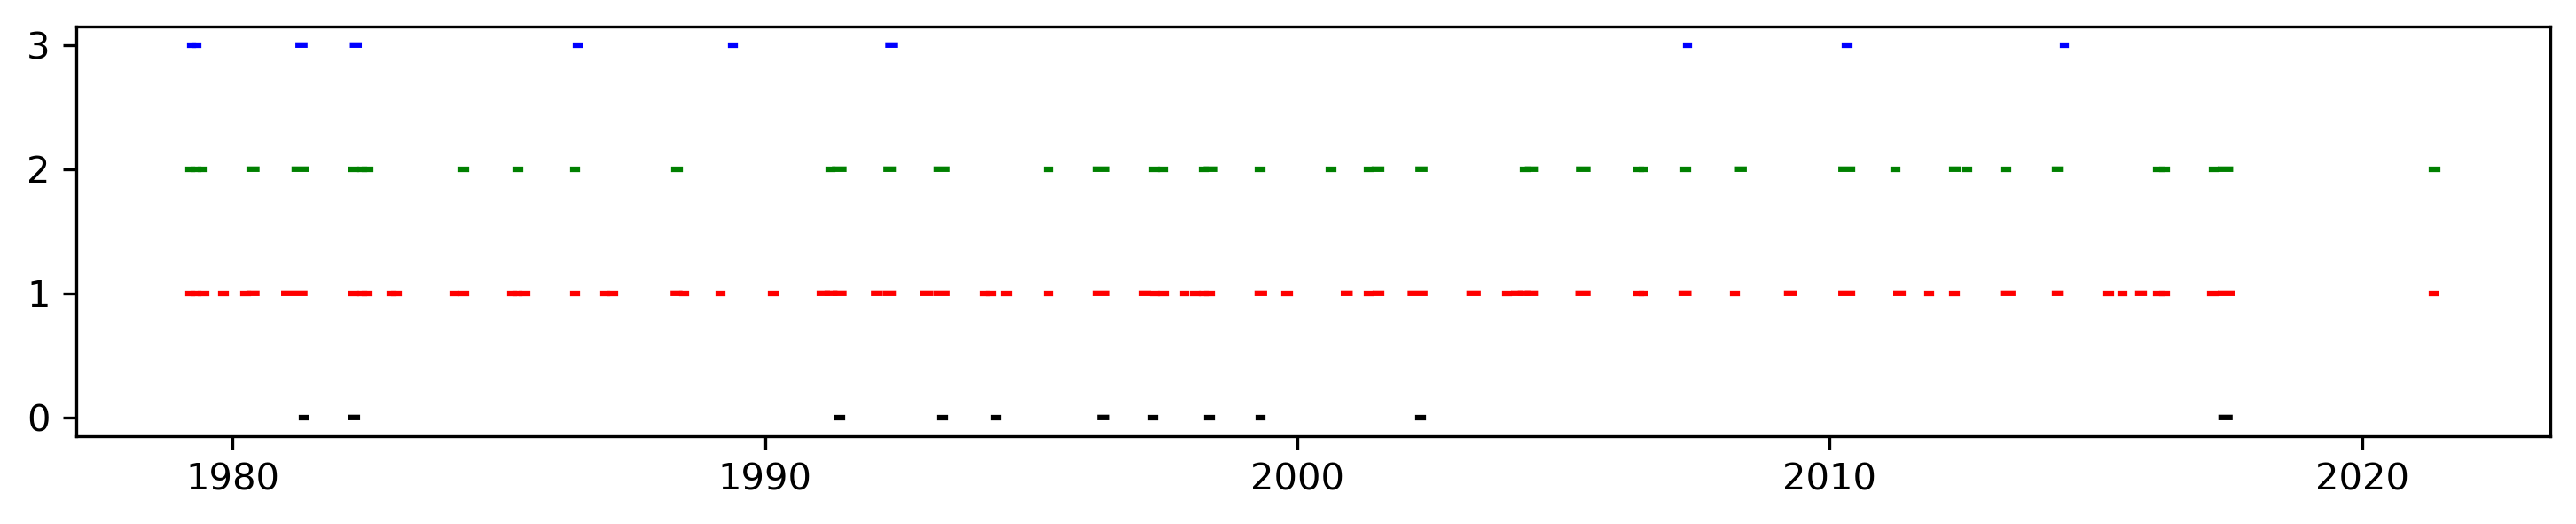

In [34]:
plt.figure(figsize=(12,2))
for i in range(len(a1)):
    plt.plot(b1[i]/24/365+1979,np.ones_like(b1[i]),'r')
for i in range(len(a2)):
    plt.plot(b2[i]/24/365+1979,2*np.ones_like(b2[i]),'g')
for i in range(len(a3)):
    plt.plot(b3[i]/24/365+1979,3*np.ones_like(b3[i]),'b')
for i in range(len(a0)):
    plt.plot(b0[i]/24/365+1979,0*np.ones_like(b0[i]),'k')
# plt.xlim(1982,1983)
print(int(1979+b0[0][0]/24/365))
print(12*((1979+b0[0][0]/24/365)-int(1979+b0[0][0]/24/365)))

In [35]:
i = 21
j = 0

era5         = xr.open_dataset(glob.glob('/g/data/rt52/era5/single-levels/reanalysis/100u/%d/100u_era5_oper_sfc_%d%02d*.nc'%(years[i],years[i],months[j]))[0])
era5         = era5.where((era5.longitude>lonlims[0])&(era5.longitude<=lonlims[1])&(era5.latitude>latlims[0])&(era5.latitude<=latlims[1]),drop=True)
era5v100     = xr.open_dataset(glob.glob('/g/data/rt52/era5/single-levels/reanalysis/100v/%d/100v_era5_oper_sfc_%d%02d*.nc'%(years[i],years[i],months[j]))[0])
era5v100     = era5v100.where((era5.longitude>lonlims[0])&(era5.longitude<=lonlims[1])&(era5.latitude>latlims[0])&(era5.latitude<=latlims[1]),drop=True)
era5         = era5.merge(era5v100)
era5msdwswrf = xr.open_dataset(glob.glob('/g/data/rt52/era5/single-levels/reanalysis/msdwswrf/%d/msdwswrf_era5_oper_sfc_%d%02d*.nc'%(years[i],years[i],months[j]))[0])
era5msdwswrf = era5msdwswrf.where((era5.longitude>lonlims[0])&(era5.longitude<=lonlims[1])&(era5.latitude>latlims[0])&(era5.latitude<=latlims[1]),drop=True)
era5         = era5.merge(era5msdwswrf)
era5         = era5.assign(w=windpower((era5.u100**2+era5.v100**2)**0.5))

/jobfs/95717059.gadi-pbs/ipykernel_1959009/2816773871.py:70: RuntimeWarning: divide by zero encountered in power
  power = (f**-beta+g**-beta)**(-1/beta)
/jobfs/95717059.gadi-pbs/ipykernel_1959009/2816773871.py:112: DeprecationWarning: Importing boxcar from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.boxcar' or the convenience function 'scipy.signal.get_window' instead.
  temp = convolve(temp0,boxcar(boxcarwidth)/boxcarwidth,'same')
/jobfs/95717059.gadi-pbs/ipykernel_1959009/2816773871.py:140: RuntimeWarning: invalid value encountered in divide
  plt.pcolor(lsmdf.longitude,lsmdf.latitude,lsmc_s3/lsmc_s3*lsmc,cmap='Reds',vmin=0,vmax=6,rasterized=True)
/jobfs/95717059.gadi-pbs/ipykernel_1959009/2816773871.py:141: RuntimeWarning: invalid value encountered in divide
  plt.pcolor(lsmdf.longitude,lsmdf.latitude,lsmc_s3/lsmc_s3*lsm,cmap='Reds',vmin=0,vmax=3,rasterized=True)
/jobfs/95717059.gadi-pbs/ipykernel_1959009/2816773871.py:153:

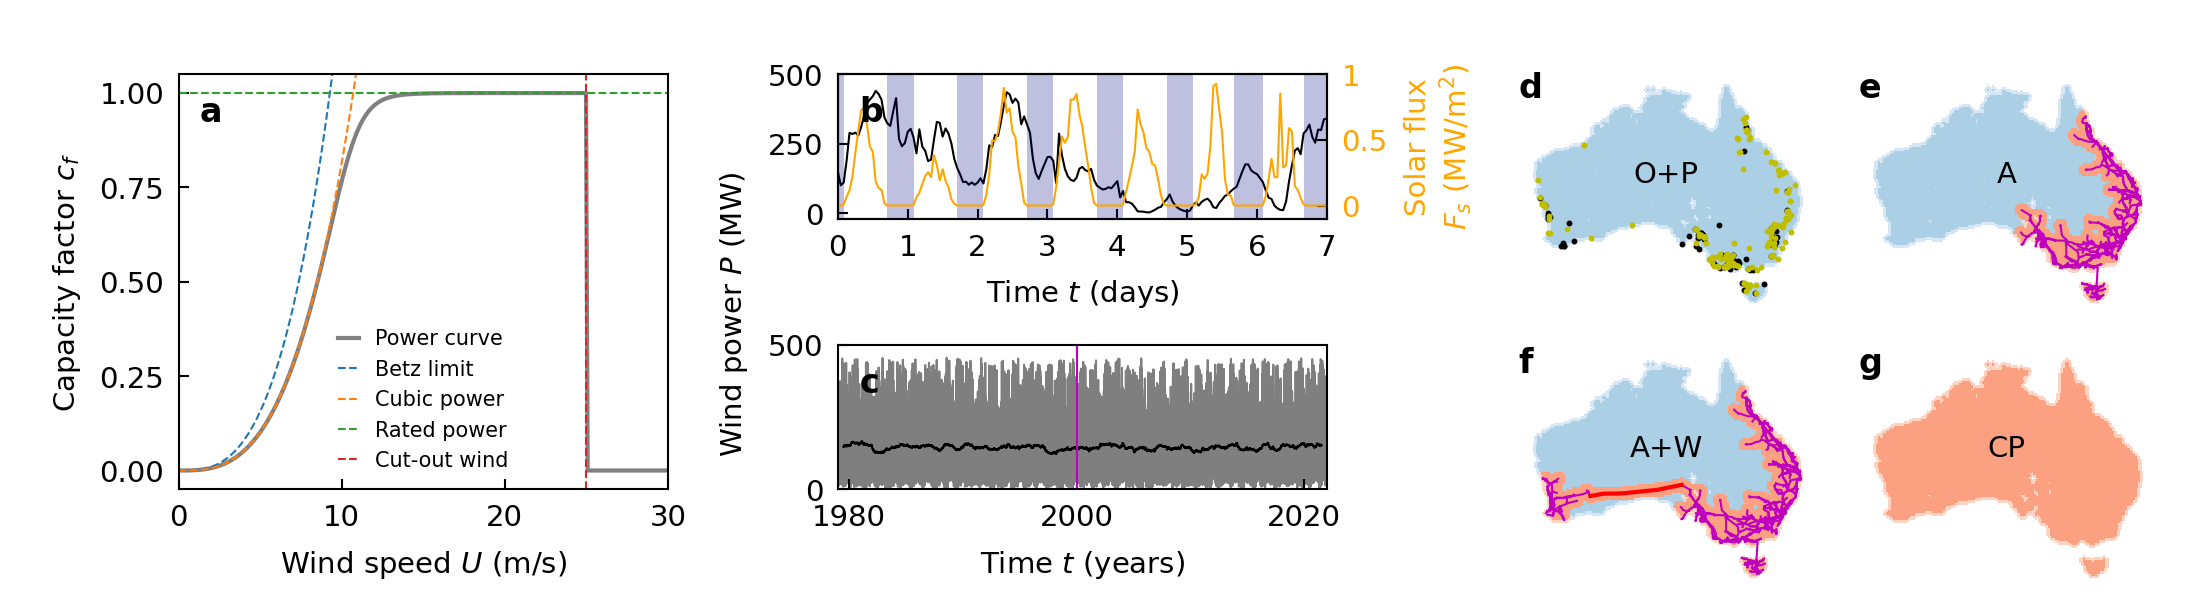

In [36]:
draft = False

cl = ['r','g','b']
lw = 0.5
ss = 2
fs = 7
alpha = 1

figw = 180
figh = 44.5
buffw0 = 0
pltspan0w = 0.16
pltspan0h = pltspan0w/((lonlims[1]-lonlims[0])/(latlims[1]-latlims[0])/figw*figh)
labbuf = 0.01
latbuf = 3
labbuf0 = 0.04
pltspan1w = 0.23
pltspan1h = 0.79
buffh0 = 0
buffh1 = 0.12
pltspan2h = (pltspan1h-buffh1*2)/2
buffw1 = 0.08
lbuff = 0.07
bbuff = 0.18

ax6l,ax6b,ax6w,ax6h = lbuff,bbuff,pltspan1w,pltspan1h
ax7l,ax7b,ax7w,ax7h = ax6l+1*(pltspan1w+buffw1),ax6b+2*buffh1+pltspan2h,pltspan1w,pltspan2h
ax8l,ax8b,ax8w,ax8h = ax6l+1*(pltspan1w+buffw1),ax6b,pltspan1w,pltspan2h
ax3l,ax3b,ax3w,ax3h = ax8l+ax8w+buffw1,0.01,pltspan0w,pltspan0h
ax1l,ax1b,ax1w,ax1h = ax3l,ax3b+1*(pltspan0h+buffh0),pltspan0w,pltspan0h
ax2l,ax2b,ax2w,ax2h = ax1l+1*(pltspan0w+buffw0),ax1b,pltspan0w,pltspan0h
ax4l,ax4b,ax4w,ax4h = ax3l+1*(pltspan0w+buffw0),ax3b,pltspan0w,pltspan0h

fig = plt.gcf()

ax00 = fig.add_axes([0,0,1,1])
ax00.patch.set_alpha(0)
ax00.set_zorder(1)
if draft:
    plt.xticks([])
    plt.yticks([])
else:
    plt.axis('off')

ax00.text(ax6l+labbuf,ax6b+ax6h-labbuf/figh*figw,'a',fontsize=8, weight='bold',va='top',ha='left')
ax00.text(ax7l+labbuf,ax7b+ax7h-labbuf/figh*figw,'b',fontsize=8, weight='bold',va='top',ha='left')
ax00.text(ax8l+labbuf,ax8b+ax8h-labbuf/figh*figw,'c',fontsize=8, weight='bold',va='top',ha='left')
ax00.text(ax1l+labbuf,ax1b+ax1h-labbuf/figh*figw-labbuf0,'d',fontsize=8, weight='bold',va='top',ha='left')
ax00.text(ax2l+labbuf,ax2b+ax2h-labbuf/figh*figw-labbuf0,'e',fontsize=8, weight='bold',va='top',ha='left')
ax00.text(ax3l+labbuf,ax3b+ax3h-labbuf/figh*figw-labbuf0,'f',fontsize=8, weight='bold',va='top',ha='left')
ax00.text(ax4l+labbuf,ax4b+ax4h-labbuf/figh*figw-labbuf0,'g',fontsize=8, weight='bold',va='top',ha='left')
ax00.set_xlim(0,1)
ax00.set_ylim(0,1)

ax6 = fig.add_axes([ax6l,ax6b,ax6w,ax6h])
wind = np.linspace(0,30,300)
rhof = 1.2
bladelength = 150/2
A = np.pi*bladelength**2
betzC = 16/27
wefficiency = 0.65
beta = 5
powerlimit = 5e+6
windlimit  = 25
windcutinspeed = 0
betzpower = wind**3*rhof*A*betzC/2
f = (wind-windcutinspeed)**3*rhof*A*betzC*wefficiency/2
f[(wind<windcutinspeed)] = 0
g = powerlimit*np.ones_like(wind)
power = (f**-beta+g**-beta)**(-1/beta)
power[(wind>windlimit)] = 0
plt.plot(wind,power/powerlimit,'grey',lw=lw*2,label='Power curve')
plt.plot(wind,betzpower/powerlimit,'--',lw=lw,label='Betz limit')
plt.plot(wind,f/powerlimit,'--',lw=lw,label='Cubic power')
plt.plot(wind,g/powerlimit,'--',lw=lw,label='Rated power')
plt.plot([windlimit,windlimit],[-0.05,1.05],'--',lw=lw,label='Cut-out wind')
# plt.plot([windcutinspeed,windcutinspeed],[-0.05,1.05],'--',lw=lw,label='Cut-in wind')
plt.ylim(-0.05,1.05)
plt.xlim(0,30)
plt.xticks([0,10,20,30],fontsize=7)
plt.yticks([0,0.25,0.5,0.75,1],fontsize=7)
plt.xlabel('Wind speed $U$ (m/s)',fontsize=7)
plt.ylabel('Capacity factor $c_f$',fontsize=7)
plt.legend(handlelength=lw*2,fontsize=5,frameon=False,loc=8)

ax7 = fig.add_axes([ax7l,ax7b,ax7w,ax7h])
smin = 10 #W/m^2
it0 = 450
it1 = int(it0+24*7+1)
tempw = era5.w[it0:it1,farmslatloninds[np.argmax(farmcapacity)][0],farmslatloninds[np.argmax(farmcapacity)][1]]
temps = era5.msdwswrf[it0:it1,farmslatloninds[np.argmax(farmcapacity)][0],farmslatloninds[np.argmax(farmcapacity)][1]]
tempt = np.arange(len(tempw))/24
ax71 = ax7.twinx()
ax7.plot(tempt,tempw*np.max(farmcapacity)*1e-6,'k',lw=lw)
ax71.plot(tempt,temps*1e-3,'orange',lw=lw)
ax71.fill_between(tempt,-1e+2,1e+3,where=temps<smin,color='navy',lw=0,alpha=0.25)
plt.xlim(tempt[0],tempt[-1])
ax7.set_ylim(-20,500)
ax71.set_ylim(-0.1,1)
ax7.set_xticks([0,1,2,3,4,5,6,7])
ax7.set_xticklabels([0,1,2,3,4,5,6,7],fontsize=7)
ax7.set_yticks([0,250,500])
ax7.set_yticklabels([0,250,500],fontsize=7)
ax71.set_yticks([0,0.5,1])
ax71.set_yticklabels([0,0.5,1],color='orange',fontsize=7)
ax7.set_xlabel('Time $t$ (days)',fontsize=7)
ax71.set_ylabel('Solar flux\n$F_s$ (MW/m$^2$)',color='orange',fontsize=7)

ax8 = fig.add_axes([ax8l,ax8b,ax8w,ax8h])
boxcarwidth = 365
temp0 = Wmaavg[:,farmslatloninds[np.argmax(farmcapacity)][0],farmslatloninds[np.argmax(farmcapacity)][1]]
temp = convolve(temp0,boxcar(boxcarwidth)/boxcarwidth,'same')
temp[:int(boxcarwidth/2)] = np.nan
temp[-int(boxcarwidth/2):] = np.nan
plt.plot(1979+np.arange(len(temp0))/365,temp0*np.max(farmcapacity)*1e-6,'k',lw=lw,alpha=0.5)
plt.plot(1979+np.arange(len(temp0))/365,temp*np.max(farmcapacity)*1e-6,'k',lw=lw)
plt.plot([2000+19/365,2000+19/365],[0,500],'m',lw=lw)
plt.xlim(1979,2022)
plt.ylim(0,500)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.xlabel('Time $t$ (years)',fontsize=7)
plt.ylabel('Wind power $P$ (MW)',fontsize=7)
ax8.yaxis.set_label_coords(-0.18,(buffh1+pltspan2h*2)/pltspan2h/2)

ax1 = fig.add_axes([ax1l,ax1b,ax1w,ax1h])
plt.pcolor(lsmdf.longitude,lsmdf.latitude,lsmc,cmap='Blues',vmin=0,vmax=6,rasterized=True)
plt.pcolor(lsmdf.longitude,lsmdf.latitude,lsm,cmap='Blues',vmin=0,vmax=3,rasterized=True)
plt.scatter(farmslatlon[:,1],farmslatlon[:,0],c='k',s=ss,lw=0,alpha=alpha)
plt.scatter(plannedfarmslatlon[:,1],plannedfarmslatlon[:,0],c='y',s=ss,lw=0,alpha=alpha)
plt.axis('square')
plt.axis('off')
plt.text(np.mean(lonlims),np.mean(latlims)+latbuf,'O+P',fontsize=fs,va='center',ha='center')
plt.xticks([])
plt.yticks([])

ax2 = fig.add_axes([ax2l,ax2b,ax2w,ax2h])
plt.pcolor(lsmdf.longitude,lsmdf.latitude,lsmc,cmap='Blues',vmin=0,vmax=6,rasterized=True)
plt.pcolor(lsmdf.longitude,lsmdf.latitude,lsm,cmap='Blues',vmin=0,vmax=3,rasterized=True)
plt.pcolor(lsmdf.longitude,lsmdf.latitude,lsmc_s3/lsmc_s3*lsmc,cmap='Reds',vmin=0,vmax=6,rasterized=True)
plt.pcolor(lsmdf.longitude,lsmdf.latitude,lsmc_s3/lsmc_s3*lsm,cmap='Reds',vmin=0,vmax=3,rasterized=True)
for l in linelatlons_s3:
    plt.plot(l[:,1],l[:,0],lw=lw,c='m')
plt.axis('square')
plt.axis('off')
plt.text(np.mean(lonlims),np.mean(latlims)+latbuf,'A',fontsize=fs,va='center',ha='center')
plt.xticks([])
plt.yticks([])

ax3 = fig.add_axes([ax3l,ax3b,ax3w,ax3h])
plt.pcolor(lsmdf.longitude,lsmdf.latitude,lsmc,cmap='Blues',vmin=0,vmax=6,rasterized=True)
plt.pcolor(lsmdf.longitude,lsmdf.latitude,lsm,cmap='Blues',vmin=0,vmax=3,rasterized=True)
plt.pcolor(lsmdf.longitude,lsmdf.latitude,lsmc_s4/lsmc_s4*lsmc,cmap='Reds',vmin=0,vmax=6,rasterized=True)
plt.pcolor(lsmdf.longitude,lsmdf.latitude,lsmc_s4/lsmc_s4*lsm,cmap='Reds',vmin=0,vmax=3,rasterized=True)
for l in linelatlons_s4:
    plt.plot(l[:,1],l[:,0],lw=lw,c='m')
plt.plot(linelatlons_s4[0][:,1],linelatlons_s4[0][:,0],lw=lw*2,c='r')
plt.axis('square')
plt.axis('off')
plt.text(np.mean(lonlims),np.mean(latlims)+latbuf,'A+W',fontsize=fs,va='center',ha='center')
plt.xticks([])
plt.yticks([])

ax4 = fig.add_axes([ax4l,ax4b,ax4w,ax4h])
plt.pcolor(lsmdf.longitude,lsmdf.latitude,lsmc,cmap='Reds',vmin=0,vmax=6,rasterized=True)
plt.pcolor(lsmdf.longitude,lsmdf.latitude,lsm,cmap='Reds',vmin=0,vmax=3,rasterized=True)
plt.axis('square')
plt.axis('off')
plt.text(np.mean(lonlims),np.mean(latlims)+latbuf,'CP',fontsize=fs,va='center',ha='center')
plt.xticks([])
plt.yticks([])

for ax in fig.axes:
    ax.tick_params(width=lw,length=lw*5,which='both',direction='in')
    ax.minorticks_off()
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(lw)

fig.set_size_inches(figw/25.4,figh/25.4,forward=True)
if draft==False:
    plt.savefig(directory+'figures/fig1.pdf',dpi=300)
    plt.savefig(directory+'figures/fig1.png',dpi=300)

In [37]:
distbins   = np.linspace(0,4.6e+6,115+1)
distbinmids = distbins[1:]-np.diff(distbins)[0]/2
corrbins   = np.linspace(-0.5,1,150+1)
griddistlsmc = np.empty_like(rlsmcs5Wmnavg)*np.nan
counter = 0
for i in range(np.shape(lsmc)[0]):
    for j in range(np.shape(lsmc)[1]):
        if ~np.isnan(lsmc[i,j]):
            temp = ((np.cumsum(-Lx,0)[i,j]-lsmc*np.cumsum(-Lx,0))**2+(np.cumsum(-Ly,1)[i,j]-lsmc*np.cumsum(-Ly,1))**2)**0.5
            griddistlsmc[counter] = np.ndarray.flatten(temp[~np.isnan(temp)])
            counter += 1

In [38]:
griddistlsmcs1 = griddistlsmc[farmslsmcflatinds][:,farmslsmcflatinds]
griddistlsmcs2 = griddistlsmc[np.concatenate((farmslsmcflatinds,plannedfarmslsmcflatinds))][:,np.concatenate((farmslsmcflatinds,plannedfarmslsmcflatinds))]
griddistlsmcs3 = griddistlsmc[lsmcs3flatinds][:,lsmcs3flatinds]
griddistlsmcs4 = griddistlsmc[lsmcs4flatinds][:,lsmcs4flatinds]

countss5,_,_ = np.histogram2d(np.ndarray.flatten(griddistlsmc),np.ndarray.flatten(rlsmcs5Wmnavg),bins=(distbins,corrbins),density=True)

corravgs1_distbins = np.asarray([np.mean(rlsmcWmnavgplannedfarms[:len(farmslsmcflatinds)][:,:len(farmslsmcflatinds)][(griddistlsmcs1>distbins[i])&(griddistlsmcs1<=distbins[i+1])]) for i in range(len(distbins)-1)])
corravgs2_distbins = np.asarray([np.mean(rlsmcWmnavgplannedfarms[(griddistlsmcs2>distbins[i])&(griddistlsmcs2<=distbins[i+1])]) for i in range(len(distbins)-1)])
corravgs3_distbins = np.asarray([np.mean(rlsmcs3Wmnavg[(griddistlsmcs3>distbins[i])&(griddistlsmcs3<=distbins[i+1])]) for i in range(len(distbins)-1)])
corravgs4_distbins = np.asarray([np.mean(rlsmcs4Wmnavg[(griddistlsmcs4>distbins[i])&(griddistlsmcs4<=distbins[i+1])]) for i in range(len(distbins)-1)])
corravgs5_distbins = np.asarray([np.mean(rlsmcs5Wmnavg[(griddistlsmc>distbins[i])&(griddistlsmc<=distbins[i+1])]) for i in range(len(distbins)-1)])


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [39]:
pdist   = pairwise_distances(rlsmcs5Wmnavg)
linkage = sch.linkage(squareform(pdist.astype('float32')), method='complete')
ninds0  = 15 #hard code
idx     = sch.fcluster(linkage, ninds0, 'maxclust')
idxmap  = np.empty((np.shape(lsmc)[0]*np.shape(lsmc)[1]))*np.nan
inds    = np.ndarray.flatten(np.argwhere(np.ndarray.flatten(lsmc)==1))
idxmap[inds] = idx
idxmap       = idxmap.reshape(np.shape(lsmc)[0],np.shape(lsmc)[1])
templatlon   = np.vstack([np.argwhere(idxmap==i)[np.argmax(np.mean(Wmnavglsmcflat,0)[idx==i])] for i in range(1,ninds0+1)])

In [40]:
indoi = 13 #hard code
pdist   = pairwise_distances(rlsmcs5Wmnavg[np.argwhere(idx==indoi).flatten()][:,np.argwhere(idx==indoi).flatten()])
nestlinkage = sch.linkage(squareform(pdist.astype('float32')), method='complete')
ninds1  = 18 #hard code
nestidx     = sch.fcluster(nestlinkage, ninds1, 'maxclust')
nestidxmap  = np.empty((np.shape(lsmc)[0]*np.shape(lsmc)[1]))*np.nan
inds    = np.ndarray.flatten(np.argwhere(np.ndarray.flatten(idxmap==indoi)))
nestidxmap[inds] = nestidx
nestidxmap       = nestidxmap.reshape(np.shape(lsmc)[0],np.shape(lsmc)[1])

/jobfs/95717059.gadi-pbs/ipykernel_1959009/3270505104.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap0 = plt.cm.get_cmap('tab20')
/jobfs/95717059.gadi-pbs/ipykernel_1959009/3270505104.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap1 = plt.cm.get_cmap('tab20b')


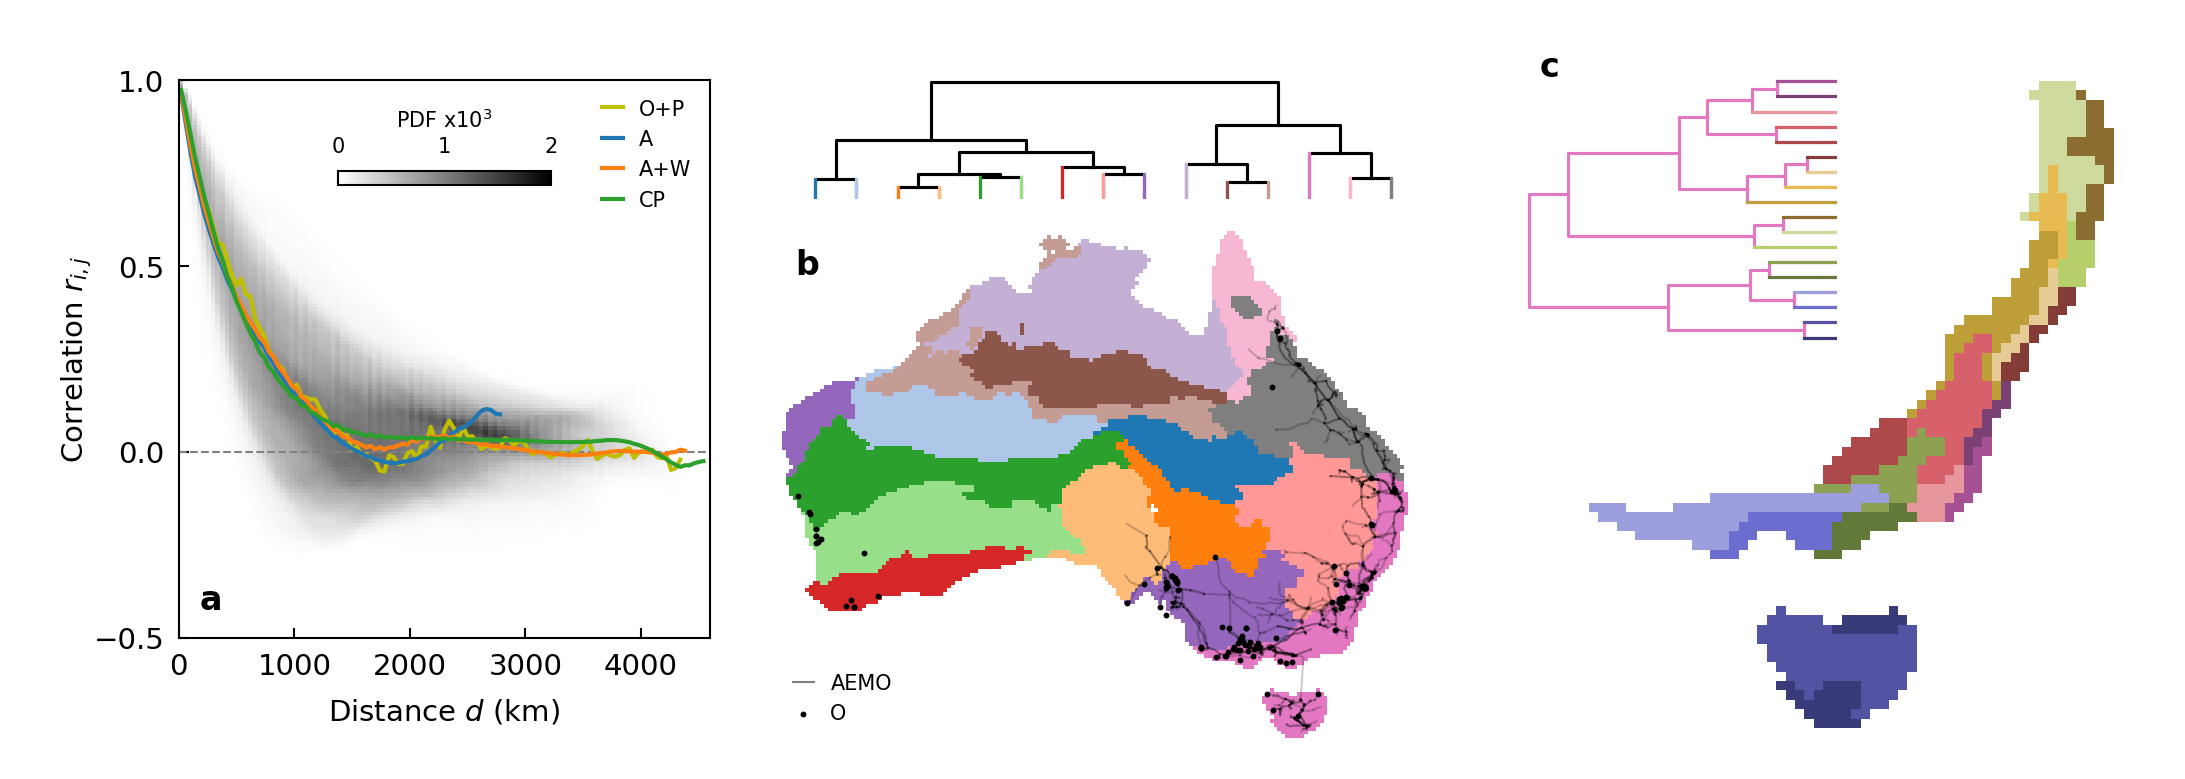

In [42]:
draft = False

cmap0 = plt.cm.get_cmap('tab20')
cmap1 = plt.cm.get_cmap('tab20b')

nestlonlims = [138,155]
nestlatlims = [-44,-25]

lw = 0.5
ss = 2
fs = 7
alpha = 1

figw = 180
figh = 59
# buffw0 = 0.13
pltspan0w = 0.3
pltspan0h = pltspan0w/((lonlims[1]-lonlims[0])/(latlims[1]-latlims[0])/figw*figh)
pltspan1h = pltspan0w/((nestlonlims[1]-nestlonlims[0])/(nestlatlims[1]-nestlatlims[0])/figw*figh)
buffh0 = 0.04
labbuf = 0.01
pltspan1w = 0.21
# pltspan1h = pltspan1w/figw*figh
pltspan2w = 0.2
pltspan2h = 0.18
buffh1 = 0.15
buffw1 = 0.00
cbw = 0.1
cbh = 0.02
buffw0 = 0.05
pltspan3w = 0.15
pltspan3h = 0.4
pltspan4w = 0.25
pltspan4h = 0.8

ax1l,ax1b,ax1w,ax1h = 0.07,0.16,pltspan4w,pltspan4h
ax2l,ax2b,ax2w,ax2h = 0.35,0.01,pltspan0w,pltspan0h
ax3l,ax3b,ax3w,ax3h = ax2l+pltspan0w+buffw0,ax2b,pltspan0w,pltspan1h
ax4l,ax4b,ax4w,ax4h = ax2l,ax2b+pltspan0h+buffh0,pltspan0w,ax1b+ax1h-(ax2b+pltspan0h+buffh0)
ax5l,ax5b,ax5w,ax5h = ax3l+buffw1,ax4b+pltspan2h-pltspan3h,pltspan3w,pltspan3h

cax0l,cax0b,cax0w,cax0h = ax1l+ax1w/2-cbw/2,ax1b+ax1h-buffh1,cbw,cbh

fig = plt.gcf()

ax00 = fig.add_axes([0,0,1,1])
ax00.patch.set_alpha(0)
ax00.set_zorder(1)
if draft:
    plt.xticks([])
    plt.yticks([])
else:
    plt.axis('off')

ax00.text(ax1l+labbuf,ax1b+labbuf/figh*figw,'a',fontsize=8, weight='bold',va='bottom',ha='left')
ax00.text(ax2l+labbuf,ax2b+ax2h-labbuf/figh*figw,'b',fontsize=8, weight='bold',va='top',ha='left')
ax00.text(ax3l+labbuf,ax3b+ax3h-labbuf/figh*figw,'c',fontsize=8, weight='bold',va='top',ha='left')
ax00.set_xlim(0,1)
ax00.set_ylim(0,1)

ax1 = fig.add_axes([ax1l,ax1b,ax1w,ax1h])
temp = np.copy(countss5)
temp[temp==0] = np.nan
p0 = plt.pcolor(distbins*1e-3,corrbins,temp.T*1e+3,cmap='binary',vmin=0,vmax=0.002,rasterized=True)
plt.plot(distbins*1e-3,np.zeros_like(distbins),'--',c='grey',lw=lw)
plt.plot(distbinmids*1e-3,corravgs2_distbins,'y',lw=lw*2,label='O+P')
plt.plot(distbinmids*1e-3,corravgs3_distbins,lw=lw*2,label='A')
plt.plot(distbinmids*1e-3,corravgs4_distbins,lw=lw*2,label='A+W')
plt.plot(distbinmids*1e-3,corravgs5_distbins,lw=lw*2,label='CP')
plt.xlim(distbins[0]*1e-3,distbins[-1]*1e-3)
plt.ylim(corrbins[0],corrbins[-1])
plt.xticks([0,1000,2000,3000,4000],fontsize=7)
plt.yticks([-0.5,0,0.5,1],fontsize=7)
plt.xlabel('Distance $d$ (km)',fontsize=7)
plt.ylabel('Correlation $r_{i,j}$',labelpad=-0.2,fontsize=7)
plt.legend(handlelength=lw*2,frameon=False,fontsize=5)

ax2 = fig.add_axes([ax2l,ax2b,ax2w,ax2h])
plt.pcolor(lsmdf.longitude,lsmdf.latitude,idxmap,cmap='tab20',
           vmin=0.5,vmax=20.5,alpha=alpha,snap=True,rasterized=True,zorder=-1)
for l in linelatlons_s3:
    plt.plot(l[:,1],l[:,0],lw=lw,c='k',alpha=0.2,zorder=-1)
plt.plot(np.nan,np.nan,lw=lw,c='grey',label='AEMO')
plt.scatter(farmslatlon[:,1],farmslatlon[:,0],c='k',s=ss,lw=0,label='O')
plt.axis('off')
plt.legend(handlelength=lw*2,fontsize=5,frameon=False,loc=3)

ax3 = fig.add_axes([ax3l,ax3b,ax3w,ax3h])
plt.pcolor(lsmdf.longitude,lsmdf.latitude,nestidxmap,cmap='tab20b',
           vmin=0.5,vmax=20.5,alpha=alpha,snap=True,rasterized=True,zorder=-1)
plt.xlim(nestlonlims)
plt.ylim(nestlatlims)
plt.axis('off')

ax4 = fig.add_axes([ax4l,ax4b,ax4w,ax4h])
d0 = sch.dendrogram(linkage,p=ninds0,truncate_mode='lastp',no_plot=True)
dnorm = np.min(np.asarray(d0['dcoord'])[np.asarray(d0['dcoord'])!=0])
tempinds0 = np.argwhere(np.asarray(d0['dcoord'])==0.0)
tempinds1 = np.argsort([d0['icoord'][tempinds0[i][0]][tempinds0[i][1]] for i in range(len(tempinds0))])
for i in range(len(d0['icoord'])):
    plt.plot(d0['icoord'][i],d0['dcoord'][i]/dnorm,c='k',lw=lw*1.5)
for i in range(ninds0):
    if tempinds0[tempinds1[i]][1]==0:
        plt.plot(d0['icoord'][tempinds0[tempinds1[i]][0]][0:2],
                 d0['dcoord'][tempinds0[tempinds1[i]][0]][0:2]/dnorm,
                 c=cmap0((i+0.5)/20),lw=lw*1.5)
    elif tempinds0[tempinds1[i]][1]==3:
        plt.plot(d0['icoord'][tempinds0[tempinds1[i]][0]][2:4],
                 d0['dcoord'][tempinds0[tempinds1[i]][0]][2:4]/dnorm,
                 c=cmap0((i+0.5)/20),lw=lw*1.5)
plt.ylim(0.9,np.max(np.asarray(d0['dcoord'])/dnorm)+2e-2)
plt.xlim(-5,ninds0*5*2)
plt.axis('off')

ax5 = fig.add_axes([ax5l,ax5b,ax5w,ax5h])
d0 = sch.dendrogram(nestlinkage,p=ninds1,truncate_mode='lastp',no_plot=True)
dnorm = np.min(np.asarray(d0['dcoord'])[np.asarray(d0['dcoord'])!=0])
tempinds0 = np.argwhere(np.asarray(d0['dcoord'])==0.0)
tempinds1 = np.argsort([d0['icoord'][tempinds0[i][0]][tempinds0[i][1]] for i in range(len(tempinds0))])
for i in range(len(d0['icoord'])):
    plt.plot(d0['dcoord'][i]/dnorm,d0['icoord'][i],c=cmap0((indoi-1+0.5)/20),lw=lw*1.5)
for i in range(ninds1):
    if tempinds0[tempinds1[i]][1]==0:
        plt.plot(d0['dcoord'][tempinds0[tempinds1[i]][0]][0:2]/dnorm,
                 d0['icoord'][tempinds0[tempinds1[i]][0]][0:2],
                 c=cmap1((i+0.5)/20),lw=lw*1.5)
    elif tempinds0[tempinds1[i]][1]==3:
        plt.plot(d0['dcoord'][tempinds0[tempinds1[i]][0]][2:4]/dnorm,
                 d0['icoord'][tempinds0[tempinds1[i]][0]][2:4],
                 c=cmap1((i+0.5)/20),lw=lw*1.5)
plt.xlim(2.9,0.8)
plt.ylim(-5,ninds1*5*2)
plt.axis('off')

cbar0_ax = fig.add_axes([cax0l,cax0b,cax0w,cax0h])
cb0 = fig.colorbar(p0, orientation='horizontal',cax=cbar0_ax, ticks=[0,0.001,0.002])
cbar0_ax.xaxis.set_label_position('top')
cbar0_ax.xaxis.set_ticks_position('top')
cb0.ax.set_xlabel('PDF x$10^3$',labelpad=2,fontsize=5)
cb0.ax.set_xticklabels([0,1,2],fontsize=5)

for ax in fig.axes:
    ax.tick_params(width=lw,length=lw*5,which='both',direction='in')
    ax.minorticks_off()
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(lw)
cb0.ax.tick_params(width=0,length=0,which='both',direction='in')
cb0.outline.set_linewidth(lw)

fig.set_size_inches(figw/25.4,figh/25.4,forward=True)
if draft==False:
    plt.savefig(directory+'figures/fig2.pdf',dpi=300)
    plt.savefig(directory+'figures/fig2.png',dpi=300)

In [43]:
ninds       = np.arange(1,np.max((nhypthfarms_s1,nhypthfarms_s2))+1)
cfnavgs3    = np.empty(len(ninds))
cfnstds3    = np.empty(len(ninds))
ravgs3      = np.empty(len(ninds))
cfnstdavgs3 = np.empty(len(ninds))
cfnavgstds3 = np.empty(len(ninds))
cfnavgs4    = np.empty(len(ninds))
cfnstds4    = np.empty(len(ninds))
ravgs4      = np.empty(len(ninds))
cfnstdavgs4 = np.empty(len(ninds))
cfnavgstds4 = np.empty(len(ninds))
cfnavgs5    = np.empty(len(ninds))
cfnstds5    = np.empty(len(ninds))
ravgs5      = np.empty(len(ninds))
cfnstdavgs5 = np.empty(len(ninds))
cfnavgstds5 = np.empty(len(ninds))
for i in range(len(ninds)):
    cfnavgs3[i]    = np.mean(Wmnavglsmcs3flat[:,lsmcs3flatindssorted[i,:i+1].astype(int)])
    cfnstds3[i]    = np.std(np.mean(Wmnavglsmcs3flat[:,lsmcs3flatindssorted[i,:i+1].astype(int)],1))
    ravgs3[i]      = np.sum(rlsmcs3Wmnavg[lsmcs3flatindssorted[i,:i+1].astype(int)][:,lsmcs3flatindssorted[i,:i+1].astype(int)]-np.eye(i+1))/((i+1)**2-(i+1))
    cfnstdavgs3[i] = np.std(np.mean(Wmnavglsmcs3flat[:,lsmcs3flatindssorted[i,:i+1].astype(int)],1))
    cfnavgstds3[i] = np.mean(np.std(Wmnavglsmcs3flat[:,lsmcs3flatindssorted[i,:i+1].astype(int)],0))
    cfnavgs4[i]    = np.mean(Wmnavglsmcs4flat[:,lsmcs4flatindssorted[i,:i+1].astype(int)])
    cfnstds4[i]    = np.std(np.mean(Wmnavglsmcs4flat[:,lsmcs4flatindssorted[i,:i+1].astype(int)],1))
    ravgs4[i]      = np.sum(rlsmcs4Wmnavg[lsmcs4flatindssorted[i,:i+1].astype(int)][:,lsmcs4flatindssorted[i,:i+1].astype(int)]-np.eye(i+1))/((i+1)**2-(i+1))
    cfnstdavgs4[i] = np.std(np.mean(Wmnavglsmcs4flat[:,lsmcs4flatindssorted[i,:i+1].astype(int)],1))
    cfnavgstds4[i] = np.mean(np.std(Wmnavglsmcs4flat[:,lsmcs4flatindssorted[i,:i+1].astype(int)],0))
    cfnavgs5[i]    = np.mean(Wmnavglsmcs5flat[:,lsmcs5flatindssorted[i,:i+1].astype(int)])
    cfnstds5[i]    = np.std(np.mean(Wmnavglsmcs5flat[:,lsmcs5flatindssorted[i,:i+1].astype(int)],1))
    ravgs5[i]      = np.sum(rlsmcs5Wmnavg[lsmcs5flatindssorted[i,:i+1].astype(int)][:,lsmcs5flatindssorted[i,:i+1].astype(int)]-np.eye(i+1))/((i+1)**2-(i+1))
    cfnstdavgs5[i] = np.std(np.mean(Wmnavglsmcs5flat[:,lsmcs5flatindssorted[i,:i+1].astype(int)],1))
    cfnavgstds5[i] = np.mean(np.std(Wmnavglsmcs5flat[:,lsmcs5flatindssorted[i,:i+1].astype(int)],0))    

/jobfs/95717059.gadi-pbs/ipykernel_1959009/3768739834.py:20: RuntimeWarning: invalid value encountered in double_scalars
  ravgs3[i]      = np.sum(rlsmcs3Wmnavg[lsmcs3flatindssorted[i,:i+1].astype(int)][:,lsmcs3flatindssorted[i,:i+1].astype(int)]-np.eye(i+1))/((i+1)**2-(i+1))
/jobfs/95717059.gadi-pbs/ipykernel_1959009/3768739834.py:25: RuntimeWarning: invalid value encountered in double_scalars
  ravgs4[i]      = np.sum(rlsmcs4Wmnavg[lsmcs4flatindssorted[i,:i+1].astype(int)][:,lsmcs4flatindssorted[i,:i+1].astype(int)]-np.eye(i+1))/((i+1)**2-(i+1))
/jobfs/95717059.gadi-pbs/ipykernel_1959009/3768739834.py:30: RuntimeWarning: invalid value encountered in double_scalars
  ravgs5[i]      = np.sum(rlsmcs5Wmnavg[lsmcs5flatindssorted[i,:i+1].astype(int)][:,lsmcs5flatindssorted[i,:i+1].astype(int)]-np.eye(i+1))/((i+1)**2-(i+1))


In [44]:
nindsfarms = np.arange(nwindfarms,nwindfarms+nplannedwindfarms+1)
rlsmcWmnavgplannedfarmssorted = rlsmcWmnavgplannedfarms[chosenfarminds][:,chosenfarminds]
cfnavgs2    = np.empty(len(nindsfarms))
ravgs2      = np.empty(len(nindsfarms))
cfnstdavgs2 = np.empty(len(nindsfarms))
cfnavgstds2 = np.empty(len(nindsfarms))
for i in range(len(nindsfarms)):
    cfnavgs2[i]    = np.mean(Wmnavglsmcs5flat[:,np.concatenate((farmslsmcflatinds,plannedfarmslsmcflatinds))[chosenfarminds][:nindsfarms[i]]])
    ravgs2[i]      = np.sum(rlsmcWmnavgplannedfarmssorted[:nindsfarms[i]][:,:nindsfarms[i]]-np.eye(nindsfarms[i]))/(nindsfarms[i]**2-nindsfarms[i])
    cfnstdavgs2[i] = np.std(np.mean(Wmnavglsmcs5flat[:,np.concatenate((farmslsmcflatinds,plannedfarmslsmcflatinds))[chosenfarminds][:nindsfarms[i]]],1))
    cfnavgstds2[i] = np.mean(np.std(Wmnavglsmcs5flat[:,np.concatenate((farmslsmcflatinds,plannedfarmslsmcflatinds))[chosenfarminds][:nindsfarms[i]]],0))

### for table S1

#### column F

In [45]:
print(np.round(cfnavgs2[0],3))
for i in range(len(nhypthfarms_s1)):
    print(np.round(cfnavgs3[ninds==nhypthfarms_s1[i]][0],3))
for i in range(len(nhypthfarms_s1)):
    print(np.round(cfnavgs4[ninds==nhypthfarms_s1[i]][0],3))
for i in range(len(nhypthfarms_s1)):
    print(np.round(cfnavgs5[ninds==nhypthfarms_s1[i]][0],3))

0.313
0.385
0.424
0.462
0.42
0.462
0.489
0.465
0.507
0.521


In [46]:
print(np.round(cfnavgs2[-1],3))
for i in range(len(nhypthfarms_s2)):
    print(np.round(cfnavgs3[ninds==nhypthfarms_s2[i]][0],3))
for i in range(len(nhypthfarms_s2)):
    print(np.round(cfnavgs4[ninds==nhypthfarms_s2[i]][0],3))
for i in range(len(nhypthfarms_s2)):
    print(np.round(cfnavgs5[ninds==nhypthfarms_s2[i]][0],3))

0.295
0.267
0.29
0.309
0.297
0.325
0.34
0.368
0.394
0.414


#### column G

In [47]:
for i in range(len(nhypthfarms_s1)):
    print(np.round(100*(cfnavgs3[ninds==nhypthfarms_s1[i]][0]-cfnavgs2[0])/cfnavgs2[0]))
for i in range(len(nhypthfarms_s1)):
    print(np.round(100*(cfnavgs4[ninds==nhypthfarms_s1[i]][0]-cfnavgs2[0])/cfnavgs2[0]))
for i in range(len(nhypthfarms_s1)):
    print(np.round(100*(cfnavgs5[ninds==nhypthfarms_s1[i]][0]-cfnavgs2[0])/cfnavgs2[0]))

23.0
35.0
48.0
34.0
47.0
56.0
49.0
62.0
66.0


In [48]:
for i in range(len(nhypthfarms_s2)):
    print(np.round(100*(cfnavgs3[ninds==nhypthfarms_s2[i]][0]-cfnavgs2[-1])/cfnavgs2[-1]))
for i in range(len(nhypthfarms_s2)):
    print(np.round(100*(cfnavgs4[ninds==nhypthfarms_s2[i]][0]-cfnavgs2[-1])/cfnavgs2[-1]))
for i in range(len(nhypthfarms_s2)):
    print(np.round(100*(cfnavgs5[ninds==nhypthfarms_s2[i]][0]-cfnavgs2[-1])/cfnavgs2[-1]))

-10.0
-2.0
5.0
0.0
10.0
15.0
25.0
33.0
40.0


#### column H

In [49]:
print(np.round(cfnstdavgs2[0]/cfnavgs2[0],3))
for i in range(len(nhypthfarms_s1)):
    print(np.round(cfnstdavgs3[ninds==nhypthfarms_s1[i]][0]/cfnavgs3[ninds==nhypthfarms_s1[i]][0],3))
for i in range(len(nhypthfarms_s1)):
    print(np.round(cfnstdavgs4[ninds==nhypthfarms_s1[i]][0]/cfnavgs4[ninds==nhypthfarms_s1[i]][0],3))
for i in range(len(nhypthfarms_s1)):
    print(np.round(cfnstdavgs5[ninds==nhypthfarms_s1[i]][0]/cfnavgs5[ninds==nhypthfarms_s1[i]][0],3))

0.465
0.3
0.285
0.299
0.255
0.253
0.256
0.213
0.201
0.204


In [50]:
print(np.round(cfnstdavgs2[-1]/cfnavgs2[-1],3))
for i in range(len(nhypthfarms_s2)):
    print(np.round(cfnstdavgs3[ninds==nhypthfarms_s2[i]][0]/cfnavgs3[ninds==nhypthfarms_s2[i]][0],3))
for i in range(len(nhypthfarms_s2)):
    print(np.round(cfnstdavgs4[ninds==nhypthfarms_s2[i]][0]/cfnavgs4[ninds==nhypthfarms_s2[i]][0],3))   
for i in range(len(nhypthfarms_s2)):
    print(np.round(cfnstdavgs5[ninds==nhypthfarms_s2[i]][0]/cfnavgs5[ninds==nhypthfarms_s2[i]][0],3))

0.399
0.355
0.347
0.337
0.295
0.282
0.278
0.219
0.214
0.21


#### column I

In [51]:
for i in range(len(nhypthfarms_s1)):
    print(np.round(-100*(cfnstdavgs3[ninds==nhypthfarms_s1[i]][0]/cfnavgs3[ninds==nhypthfarms_s1[i]][0]-cfnstdavgs2[0]/cfnavgs2[0])/(cfnstdavgs2[0]/cfnavgs2[0])))
for i in range(len(nhypthfarms_s1)):
    print(np.round(-100*(cfnstdavgs4[ninds==nhypthfarms_s1[i]][0]/cfnavgs4[ninds==nhypthfarms_s1[i]][0]-cfnstdavgs2[0]/cfnavgs2[0])/(cfnstdavgs2[0]/cfnavgs2[0])))
for i in range(len(nhypthfarms_s1)):
    print(np.round(-100*(cfnstdavgs5[ninds==nhypthfarms_s1[i]][0]/cfnavgs5[ninds==nhypthfarms_s1[i]][0]-cfnstdavgs2[0]/cfnavgs2[0])/(cfnstdavgs2[0]/cfnavgs2[0])))

36.0
39.0
36.0
45.0
46.0
45.0
54.0
57.0
56.0


In [52]:
for i in range(len(nhypthfarms_s2)):
    print(np.round(-100*(cfnstdavgs3[ninds==nhypthfarms_s2[i]][0]/cfnavgs3[ninds==nhypthfarms_s2[i]][0]-cfnstdavgs2[-1]/cfnavgs2[-1])/(cfnstdavgs2[-1]/cfnavgs2[-1])))
for i in range(len(nhypthfarms_s2)):
    print(np.round(-100*(cfnstdavgs4[ninds==nhypthfarms_s2[i]][0]/cfnavgs4[ninds==nhypthfarms_s2[i]][0]-cfnstdavgs2[-1]/cfnavgs2[-1])/(cfnstdavgs2[-1]/cfnavgs2[-1])))
for i in range(len(nhypthfarms_s2)):
    print(np.round(-100*(cfnstdavgs5[ninds==nhypthfarms_s2[i]][0]/cfnavgs5[ninds==nhypthfarms_s2[i]][0]-cfnstdavgs2[-1]/cfnavgs2[-1])/(cfnstdavgs2[-1]/cfnavgs2[-1])))
    

11.0
13.0
16.0
26.0
29.0
30.0
45.0
46.0
47.0


#### column J

In [53]:
print(np.round(ravgs2[0],3))
for i in range(len(nhypthfarms_s1)):
    print(np.round(ravgs3[ninds==nhypthfarms_s1[i]][0],3))
for i in range(len(nhypthfarms_s1)):
    print(np.round(ravgs4[ninds==nhypthfarms_s1[i]][0],3))
for i in range(len(nhypthfarms_s1)):
    print(np.round(ravgs5[ninds==nhypthfarms_s1[i]][0],3))

0.333
0.188
0.153
0.148
0.145
0.124
0.106
0.117
0.085
0.074


In [54]:
print(np.round(ravgs2[-1],3))
for i in range(len(nhypthfarms_s2)):
    print(np.round(ravgs3[ninds==nhypthfarms_s2[i]][0],3))
for i in range(len(nhypthfarms_s2)):
    print(np.round(ravgs4[ninds==nhypthfarms_s2[i]][0],3))
for i in range(len(nhypthfarms_s2)):
    print(np.round(ravgs5[ninds==nhypthfarms_s2[i]][0],3))

0.238
0.214
0.216
0.212
0.173
0.165
0.165
0.121
0.121
0.119


In [55]:
nbins = 101
counts = np.empty((np.shape(powersums)[1],np.shape(powersums)[1],np.shape(powersums)[1],nbins-1))
binss1     = np.logspace(-0.5,1,nbins)
countss1,_ = np.histogram(powersums1*1e-9,bins=binss1,density=True)
for j in range(np.shape(powersums)[1]):
    for k in range(np.shape(powersums)[2]):
        counts[0,j,k],_ = np.histogram(powersums[0,j,k]*1e-9,bins=binss1,density=True) 
binss2     = np.logspace(0.5,2.5,nbins)
countss2,_ = np.histogram(powersums2*1e-9,bins=binss2,density=True)
for j in range(np.shape(powersums)[1]):
    for k in range(np.shape(powersums)[2]):
        counts[1,j,k],_ = np.histogram(powersums[1,j,k]*1e-9,bins=binss2,density=True)

/jobfs/95717059.gadi-pbs/ipykernel_1959009/165423148.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10')


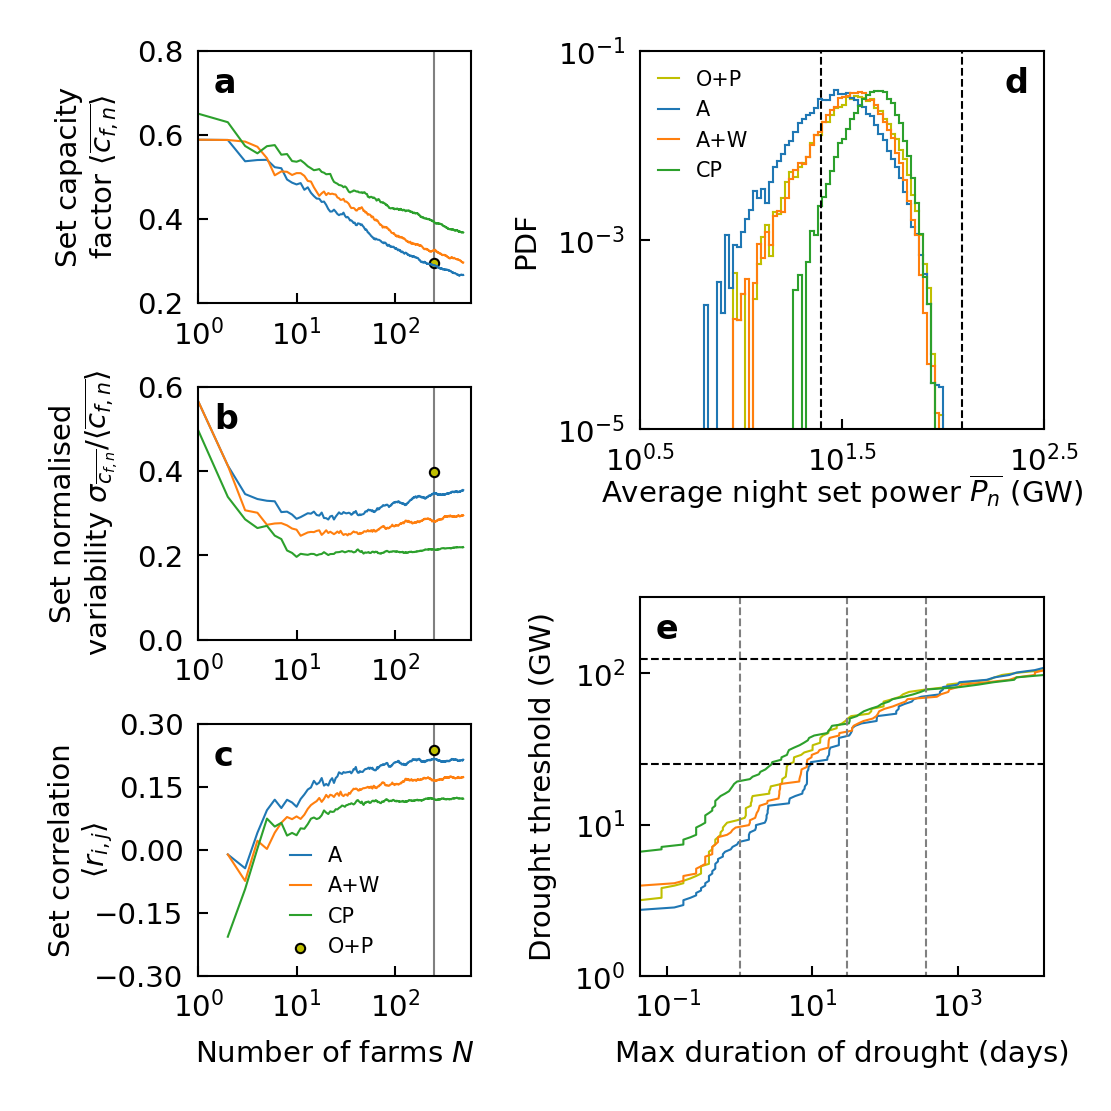

In [56]:
draft = False

cmap = plt.cm.get_cmap('tab10')

cl = ['r','g','b']
sXy = ['A','A+W','CP']
lw = 0.5
ss = 5
fs = 7

figw = 89
figh = 89
pltspan0w = 0.26
pltspan0h = 0.24
buffh0 = 0.08

pltspan1w = 0.385
pltspan1h = 0.36
buffw1 = 0.16
buffh1 = 0.16

labbuf = 0.015

ax2l,ax2b,ax2w,ax2h = 0.16,0.1,pltspan0w,pltspan0h
ax1l,ax1b,ax1w,ax1h = ax2l,ax2b+1*(pltspan0h+buffh0),pltspan0w,pltspan0h
ax0l,ax0b,ax0w,ax0h = ax2l,ax2b+2*(pltspan0h+buffh0),pltspan0w,pltspan0h
ax3l,ax3b,ax3w,ax3h = ax2l+pltspan0w+buffw1,ax2b,pltspan1w,pltspan1h
ax4l,ax4b,ax4w,ax4h = ax3l,ax3b+ax3h+buffh1,pltspan1w,pltspan1h

fig = plt.gcf()

ax00 = fig.add_axes([0,0,1,1])
ax00.patch.set_alpha(0)
ax00.set_zorder(1)
if draft:
    plt.xticks([])
    plt.yticks([])
else:
    plt.axis('off')

ax00.text(ax0l+labbuf,ax0b+ax0h-labbuf/figh*figw,'a',fontsize=8, weight='bold',va='top',ha='left')
ax00.text(ax1l+labbuf,ax1b+ax1h-labbuf/figh*figw,'b',fontsize=8, weight='bold',va='top',ha='left')
ax00.text(ax2l+labbuf,ax2b+ax2h-labbuf/figh*figw,'c',fontsize=8, weight='bold',va='top',ha='left')
ax00.text(ax3l+labbuf,ax3b+ax3h-labbuf/figh*figw,'e',fontsize=8, weight='bold',va='top',ha='left')
ax00.text(ax4l+ax4w-labbuf,ax4b+ax4h-labbuf/figh*figw,'d',fontsize=8, weight='bold',va='top',ha='right')
ax00.set_xlim(0,1)
ax00.set_ylim(0,1)

ax0 = fig.add_axes([ax0l,ax0b,ax0w,ax0h])
plt.plot(ninds,cfnavgs3,lw=lw)
plt.plot(ninds,cfnavgs4,lw=lw)
plt.plot(ninds,cfnavgs5,lw=lw)
plt.scatter(nwindfarms+nplannedwindfarms,cfnavgs2[-1],fc='y',ec='k',s=ss,lw=lw)
plt.plot([nwindfarms+nplannedwindfarms,
          nwindfarms+nplannedwindfarms],[0.2,0.8],c='grey',lw=lw,zorder=-1)
plt.xscale('log')
plt.xlim(1,6e+2)
plt.ylim(0.2,0.8)
plt.xticks([1,10,100],fontsize=7)
plt.yticks([0.2,0.4,0.6,0.8],fontsize=7)
plt.ylabel('Set capacity\nfactor $\\langle \\overline{c_{f,n}}\\rangle$',fontsize=7)

ax1 = fig.add_axes([ax1l,ax1b,ax1w,ax1h])
plt.plot(ninds,cfnstdavgs3/cfnavgs3,lw=lw)
plt.plot(ninds,cfnstdavgs4/cfnavgs4,lw=lw)
plt.plot(ninds,cfnstdavgs5/cfnavgs5,lw=lw)
plt.scatter(nwindfarms+nplannedwindfarms,cfnstdavgs2[-1]/cfnavgs2[-1],fc='y',ec='k',s=ss,lw=lw)
plt.plot([nwindfarms+nplannedwindfarms,
          nwindfarms+nplannedwindfarms],[0,0.6],c='grey',lw=lw,zorder=-1)
plt.xscale('log')
plt.xlim(1,6e+2)
plt.ylim(0.0,0.6)
plt.xticks([1,10,100],fontsize=7)
plt.yticks([0.0,0.2,0.4,0.6],fontsize=7)
plt.ylabel('Set normalised\nvariability $\\sigma_{\\overline{c_{f,n}}}/\\langle\\overline{c_{f,n}}\\rangle$',fontsize=7)

ax2 = fig.add_axes([ax2l,ax2b,ax2w,ax2h])
plt.plot(ninds,ravgs3,lw=lw,label='A')
plt.plot(ninds,ravgs4,lw=lw,label='A+W')
plt.plot(ninds,ravgs5,lw=lw,label='CP')
plt.scatter(nwindfarms+nplannedwindfarms,ravgs2[-1],fc='y',ec='k',s=ss,lw=lw,label='O+P')
plt.plot([nwindfarms+nplannedwindfarms,
          nwindfarms+nplannedwindfarms],[-0.3,0.3],c='grey',lw=lw,zorder=-1)
plt.xscale('log')
plt.xlim(1,6e+2)
plt.ylim(-0.3,0.3)
plt.xticks([1,10,100],fontsize=7)
plt.yticks([-0.3,-0.15,0,0.15,0.3],fontsize=7)
plt.ylabel('Set correlation\n$\\langle r_{i,j}\\rangle$',fontsize=7,labelpad=-5)
plt.xlabel('Number of farms $N$',fontsize=7)
plt.legend(handlelength=lw*2,frameon=False,fontsize=5,loc=8)

ax3 = fig.add_axes([ax3l,ax3b,ax3w,ax3h])
plt.plot(droughts2/24,tempthr*1e-9,lw=lw,c='y')
for j in range(np.shape(powertimeseries)[1]):
    k = 1
    plt.plot(drought[1,j,k]/24,tempthr*1e-9,c=cmap(j/10+0.05),lw=lw)
plt.plot([1,1],[tempthr[0]*1e-9,tempthr[-1]*1e-9],'--',c='grey',lw=lw)
plt.plot([365/12,365/12],[tempthr[0]*1e-9,tempthr[-1]*1e-9],'--',c='grey',lw=lw)
plt.plot([365,365],[tempthr[0]*1e-9,tempthr[-1]*1e-9],'--',c='grey',lw=lw)
plt.plot([1/24,len(powertimeseriess2)/24],[25,25],'--k',lw=lw)
plt.plot([1/24,len(powertimeseriess2)/24],[(np.sum(plannedfarmcapacity)+np.sum(farmcapacity))*1e-9,(np.sum(plannedfarmcapacity)+np.sum(farmcapacity))*1e-9],'--k',lw=lw)
plt.xscale('log')
plt.yscale('log')
plt.xlim(1/24,len(powertimeseriess2)/24)
plt.ylim(10**0,10**2.5)
plt.xticks([1e-1,1e+1,1e+3],fontsize=7)
plt.yticks([1e+0,1e+1,1e+2],fontsize=7)
plt.xlabel('Max duration of drought (days)',fontsize=7)
plt.ylabel('Drought threshold (GW)',fontsize=7)

ax4 = fig.add_axes([ax4l,ax4b,ax4w,ax4h])
for i in range(len(countss2)):
    plt.plot([binss2[i],binss2[i+1]],[countss2[i],countss2[i]],c='y',lw=lw)
    if i==0:
        plt.plot([binss2[i],binss2[i]],[0,countss2[i]],c='y',lw=lw)
    else:
        plt.plot([binss2[i],binss2[i]],[countss2[i-1],countss2[i]],c='y',lw=lw)
plt.plot(np.nan,np.nan,c='y',lw=lw,label='O+P')
for j in range(np.shape(powersums)[1]):
    k = 1
    for i in range(len(countss2)):
        plt.plot([binss2[i],binss2[i+1]],[counts[1,j,k,i],counts[1,j,k,i]],c=cmap(j/10+0.05),lw=lw)
        if i==0:
            plt.plot([binss2[i],binss2[i]],[0,counts[1,j,k,i]],c=cmap(j/10+0.05),lw=lw)
        else:
            plt.plot([binss2[i],binss2[i]],[counts[1,j,k,i-1],counts[1,j,k,i]],c=cmap(j/10+0.05),lw=lw)
    plt.plot(np.nan,np.nan,c=cmap(j/10+0.05),lw=lw,label='%s'%(sXy[j]))
plt.plot([25,25],[1e-5,1e-1],'--k',lw=lw)
plt.plot([(np.sum(plannedfarmcapacity)+np.sum(farmcapacity))*1e-9,(np.sum(plannedfarmcapacity)+np.sum(farmcapacity))*1e-9],[1e-5,1e-1],'--k',lw=lw)
plt.xlim(binss2[0],binss2[-1])
plt.ylim(1e-5,1e-1)
plt.xscale('log')
plt.yscale('log')
plt.xticks([10**0.5,10**1.5,10**2.5],['$10^{0.5}$','$10^{1.5}$','$10^{2.5}$'],fontsize=7)
plt.yticks([1e-5,1e-3,1e-1],fontsize=7)
plt.xlabel('Average night set power $\\overline{P_n}$ (GW)',fontsize=7,labelpad=-1)
plt.ylabel('PDF',fontsize=7)
plt.legend(handlelength=lw*2,frameon=False,fontsize=5,loc=0)

for ax in fig.axes:
    ax.tick_params(width=lw,length=lw*5,which='both',direction='in')
    ax.minorticks_off()
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(lw)

fig.set_size_inches(figw/25.4,figh/25.4,forward=True)
if draft==False:
    plt.savefig(directory+'figures/fig3.pdf',dpi=300)
    plt.savefig(directory+'figures/fig3.png',dpi=300)

In [57]:
wmaavgmonth = np.empty((len(years),len(months),len(lsmdf.latitude),len(lsmdf.longitude)))
wmnavgmonth = np.empty((len(years),len(months),len(lsmdf.latitude),len(lsmdf.longitude)))
for i in range(len(years)):
    for j in range(len(months)):
        with open(directory+'era5-analysis-bymonth/%04d_%02d_analysis.pkl'%(years[i],months[j]),'rb') as f:
            (wmaavg,wmamin,wmnavg,wmnmin) = pickle.load(f)
        wmaavgmonth[i,j] = np.mean(wmaavg,0)
        wmnavgmonth[i,j] = np.mean(wmnavg,0)
        print('year %04d, month %02d'%(years[i],months[j]),end='\r')
wmaavgmonthflat = wmaavgmonth.reshape(np.shape(wmaavgmonth)[0],np.shape(wmaavgmonth)[1],np.shape(wmaavgmonth)[2]*np.shape(wmaavgmonth)[3])
wmnavgmonthflat = wmnavgmonth.reshape(np.shape(wmnavgmonth)[0],np.shape(wmnavgmonth)[1],np.shape(wmnavgmonth)[2]*np.shape(wmnavgmonth)[3])

In [58]:
climdex_name = ['Nino3.4','SOI','PDO','DMI','SAM','MJO']
climdex_file = ['nino34.long.anom.data.csv',
                'soi.long.data.csv',
                'pdo.long.data.csv',
                'dmi.had.long.data.csv',
                'sam.20crv2c.long.data.csv',
                'omi.1x.csv']

nanvalues = [-99.99,-99.99,-9.90,-9999.000,-999,None]

climdex_years = [[] for k in range(len(climdex_name))]
climdex       = [[] for k in range(len(climdex_name))]

for k in range(len(climdex_name)):
    df = pd.read_csv(directory+'climate-indices/'+climdex_file[k],header=None)
    if k==5:
        tempyears = np.arange(df.iloc[0,0],df.iloc[-1,0]+1)
        dfarray   = np.asarray(df)
        tempindex = np.empty((len(tempyears),len(months)))
        mjo_day = np.arctan2(dfarray[:,5],dfarray[:,4])
        for i in range(len(tempyears)):
            for j in range(len(months)):
                tempindex[i,j] = np.angle(np.sum(dfarray[(dfarray[:,0]==tempyears[i])&(dfarray[:,1]==months[j]),4]+1j*dfarray[(dfarray[:,0]==tempyears[i])&(dfarray[:,1]==months[j]),5]))

    else:
        tempyears = np.asarray(df.iloc[:,0])
        tempindex = np.asarray(df.iloc[:,1:])
    
    tempindex[tempindex==nanvalues[k]] = np.nan

    climdex_years[k] = tempyears
    climdex[k]       = tempindex

In [59]:
ensomap = np.empty((np.shape(lsmc)[0],np.shape(lsmc)[1]))
temp0 = np.mean(wmaavgmonth,1)
k = 0
temp1 = np.mean(climdex[k],1)
tempyears = climdex_years[k][~np.isnan(temp1)]
temp1 = temp1[~np.isnan(temp1)]
temp000 = temp0[(years>=np.max((np.min(years),np.min(tempyears))))&(years<=np.min((np.max(years),np.max(tempyears))))]
temp111 = temp1[(tempyears>=np.max((np.min(years),np.min(tempyears))))&(tempyears<=np.min((np.max(years),np.max(tempyears))))]
ensomap = np.sum((temp000-np.mean(temp000,0))*(temp111[:,None,None]-np.mean(temp111)),0)/(np.sum((temp000-np.mean(temp000,0))**2,0)*np.sum((temp111-np.mean(temp111))**2))**0.5

/jobfs/95717059.gadi-pbs/ipykernel_1959009/1267401831.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10')
/jobfs/95717059.gadi-pbs/ipykernel_1959009/1267401831.py:91: DeprecationWarning: Importing boxcar from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.boxcar' or the convenience function 'scipy.signal.get_window' instead.
  temp = convolve(powersums2,boxcar(boxcarwidth)/boxcarwidth,'same')
/jobfs/95717059.gadi-pbs/ipykernel_1959009/1267401831.py:95: DeprecationWarning: Importing boxcar from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.boxcar' or the convenience function 'scipy.signal.get_window' instead.
  temp = convolve(powersums[1,0,1],boxcar(boxcarwidth)/boxcarwidth

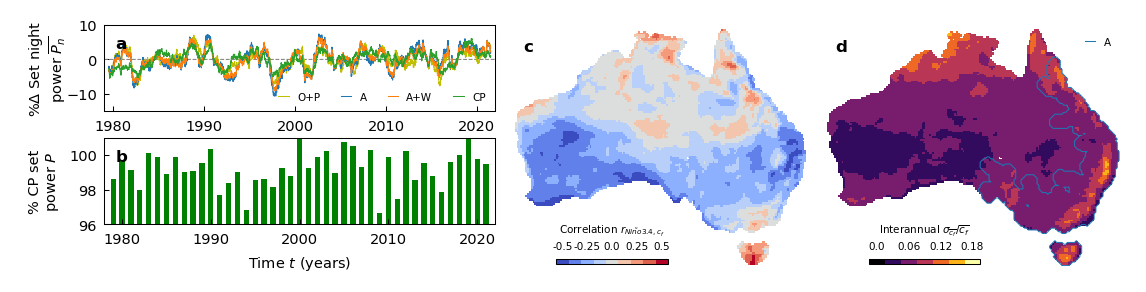

In [79]:
draft = False

lw = 0.5
ss = 2
fs = 7

cmap = plt.cm.get_cmap('tab10')
boxcarwidth = 365

figw = 189
figh = 44.5
buffw0 = 0.04
buffw1 = 0.015
pltspan0w = 0.265
pltspan0h = pltspan0w/((lonlims[1]-lonlims[0])/(latlims[1]-latlims[0])/figw*figh)
buffh0 = 0.1
labbuf = 0.01
pltspan1w = 0.35
pltspan1h = 0.33

cbw = 0.1
cbh = 0.02

ax1l,ax1b,ax1w,ax1h = 0.08,0.2,pltspan1w,pltspan1h
ax0l,ax0b,ax0w,ax0h = ax1l,ax1b+pltspan1h+buffh0,pltspan1w,pltspan1h

ax2l,ax2b,ax2w,ax2h = ax1l+pltspan1w+buffw1,0.04,pltspan0w,pltspan0h
ax3l,ax3b,ax3w,ax3h = ax2l+pltspan0w+buffw1,ax2b,pltspan0w,pltspan0h

cax0l,cax0b,cax0w,cax0h = ax2l+buffw0,ax2b+labbuf,cbw,cbh
cax1l,cax1b,cax1w,cax1h = ax3l+buffw0,ax3b+labbuf,cbw,cbh

fig = plt.gcf()
fig.set_dpi(150)

ax00 = fig.add_axes([0,0,1,1])
ax00.patch.set_alpha(0)
ax00.set_zorder(1)
if draft:
    plt.xticks([])
    plt.yticks([])
else:
    plt.axis('off')

ax00.text(ax0l+labbuf,ax0b+ax0h-labbuf/figh*figw,'a',fontsize=8, weight='bold',va='top',ha='left')
ax00.text(ax1l+labbuf,ax1b+ax1h-labbuf/figh*figw,'b',fontsize=8, weight='bold',va='top',ha='left')
ax00.text(ax2l+labbuf,ax2b+ax2h-labbuf/figh*figw,'c',fontsize=8, weight='bold',va='top',ha='left')
ax00.text(ax3l+labbuf,ax3b+ax3h-labbuf/figh*figw,'d',fontsize=8, weight='bold',va='top',ha='left')
ax00.set_xlim(0,1)
ax00.set_ylim(0,1)

ax2 = fig.add_axes([ax2l,ax2b,ax2w,ax2h])
levels0 = np.linspace(-0.5,0.5,9)
leveledges0 = np.hstack((levels0-np.diff(levels0)[0]/2,levels0[-1]+np.diff(levels0)[0]/2))
cmap0 = plt.get_cmap('coolwarm')
norm0 = BoundaryNorm(leveledges0, ncolors=cmap0.N, clip=True)
p0 = plt.pcolor(lsmdf.longitude,lsmdf.latitude,
                lsmc*ensomap,
                cmap=cmap0,norm=norm0,rasterized=True)
plt.axis('off')

ax3 = fig.add_axes([ax3l,ax3b,ax3w,ax3h])
levels1 = np.linspace(0,0.18,7)
leveledges1 = np.hstack((levels1-np.diff(levels1)[0]/2,levels1[-1]+np.diff(levels1)[0]/2))
cmap1 = plt.get_cmap('inferno')
norm1 = BoundaryNorm(leveledges1, ncolors=cmap1.N, clip=True)
p1 = plt.pcolor(lsmdf.longitude,lsmdf.latitude,
           lsmc*np.std(np.mean(wmaavgmonth,1),0)/np.mean(wmaavgmonth,(0,1)),
           cmap=cmap1,norm=norm1,rasterized=True)
temp = np.copy(lsmcs3)
temp[np.isnan(temp)] = 0
plt.contour(lsmdf.longitude,lsmdf.latitude,temp,levels=[0.01],colors=[cmap(0.05)],linewidths=[lw])
plt.plot(np.nan,np.nan,c=cmap(0.05),lw=lw,label='A')
plt.axis('off')
plt.legend(handlelength=lw*2,frameon=False,fontsize=5)

ax1 = fig.add_axes([ax1l,ax1b,ax1w,ax1h])
for i in range(len(years)):
    plt.fill_between([years[i]-0.3,years[i]+0.3],[np.mean(powertimeseriess5s2c2byyear[i])/np.mean(powertimeseries[1,2,1])*100,
                                                          np.mean(powertimeseriess5s2c2byyear[i])/np.mean(powertimeseries[1,2,1])*100],
                     facecolor='g',edgecolor='None')
plt.xlim(years[0]-1,years[-1]+1)
plt.ylim(96,101)
plt.xticks([1980,1990,2000,2010,2020],fontsize=7)
plt.yticks([96,98,100],fontsize=7)
plt.xlabel('Time $t$ (years)',fontsize=7)
plt.ylabel('% CP set\npower $P$',fontsize=7)

ax0 = fig.add_axes([ax0l,ax0b,ax0w,ax0h])
plt.plot(1979+np.arange(len(powersums2))/365,np.zeros_like(powersums2),'--',c='grey',lw=lw)
temp = convolve(powersums2,boxcar(boxcarwidth)/boxcarwidth,'same')
temp[:int(boxcarwidth/2)] = np.nan
temp[-int(boxcarwidth/2):] = np.nan
plt.plot(1979+np.arange(len(temp))/365,(temp/np.mean(powersums2)-1)*100,c='y',lw=lw,label='O+P')
temp = convolve(powersums[1,0,1],boxcar(boxcarwidth)/boxcarwidth,'same')
temp[:int(boxcarwidth/2)] = np.nan
temp[-int(boxcarwidth/2):] = np.nan
plt.plot(1979+np.arange(len(temp))/365,(temp/np.mean(powersums[1,0,1])-1)*100,lw=lw,label='A')
temp = convolve(powersums[1,1,1],boxcar(boxcarwidth)/boxcarwidth,'same')
temp[:int(boxcarwidth/2)] = np.nan
temp[-int(boxcarwidth/2):] = np.nan
plt.plot(1979+np.arange(len(temp))/365,(temp/np.mean(powersums[1,1,1])-1)*100,lw=lw,label='A+W')
temp = convolve(powersums[1,2,1],boxcar(boxcarwidth)/boxcarwidth,'same')
temp[:int(boxcarwidth/2)] = np.nan
temp[-int(boxcarwidth/2):] = np.nan
plt.plot(1979+np.arange(len(temp))/365,(temp/np.mean(powersums[1,2,1])-1)*100,lw=lw,label='CP')
plt.xlim(years[0],years[-1]+1)
plt.ylim(-15,10)
plt.xticks([1980,1990,2000,2010,2020],fontsize=7)
plt.yticks([-10,0,10],fontsize=7)
# plt.xlabel('Time $t$ (years)',fontsize=7)
plt.ylabel('%$\\Delta$ Set night\npower $\\overline{P_n}$',labelpad=-1,fontsize=7)
plt.legend(handlelength=lw*2,frameon=False,fontsize=5,ncol=4)

cbar0_ax = fig.add_axes([cax0l,cax0b,cax0w,cax0h])
cb0 = fig.colorbar(p0, orientation='horizontal',cax=cbar0_ax, ticks=levels0[::2])
cbar0_ax.xaxis.set_label_position('top')
cbar0_ax.xaxis.set_ticks_position('top')
cb0.ax.set_xlabel('Correlation $r_{Ni\~{n}o3.4,c_f}$',fontsize=5)
cb0.ax.set_xticklabels(levels0[::2],fontsize=5)

cbar1_ax = fig.add_axes([cax1l,cax1b,cax1w,cax1h])
cb1 = fig.colorbar(p1, orientation='horizontal',cax=cbar1_ax, ticks=levels1[::2])
cbar1_ax.xaxis.set_label_position('top')
cbar1_ax.xaxis.set_ticks_position('top')
cb1.ax.set_xlabel('Interannual $\\sigma_{\\overline{c_f}}/\\overline{c_f}$',fontsize=5)
cb1.ax.set_xticklabels(levels1[::2],fontsize=5)

for ax in fig.axes:
    ax.tick_params(width=lw,length=lw*5,which='both',direction='in')
    ax.minorticks_off()
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(lw)
cb0.ax.tick_params(width=0,length=0,which='both',direction='in')
cb0.outline.set_linewidth(lw)
cb1.ax.tick_params(width=0,length=0,which='both',direction='in')
cb1.outline.set_linewidth(lw)

fig.set_size_inches(figw/25.4,figh/25.4,forward=True)
if draft==False:
    plt.savefig(directory+'figures/fig4.pdf',dpi=300)
    plt.savefig(directory+'figures/fig4.png',dpi=300)

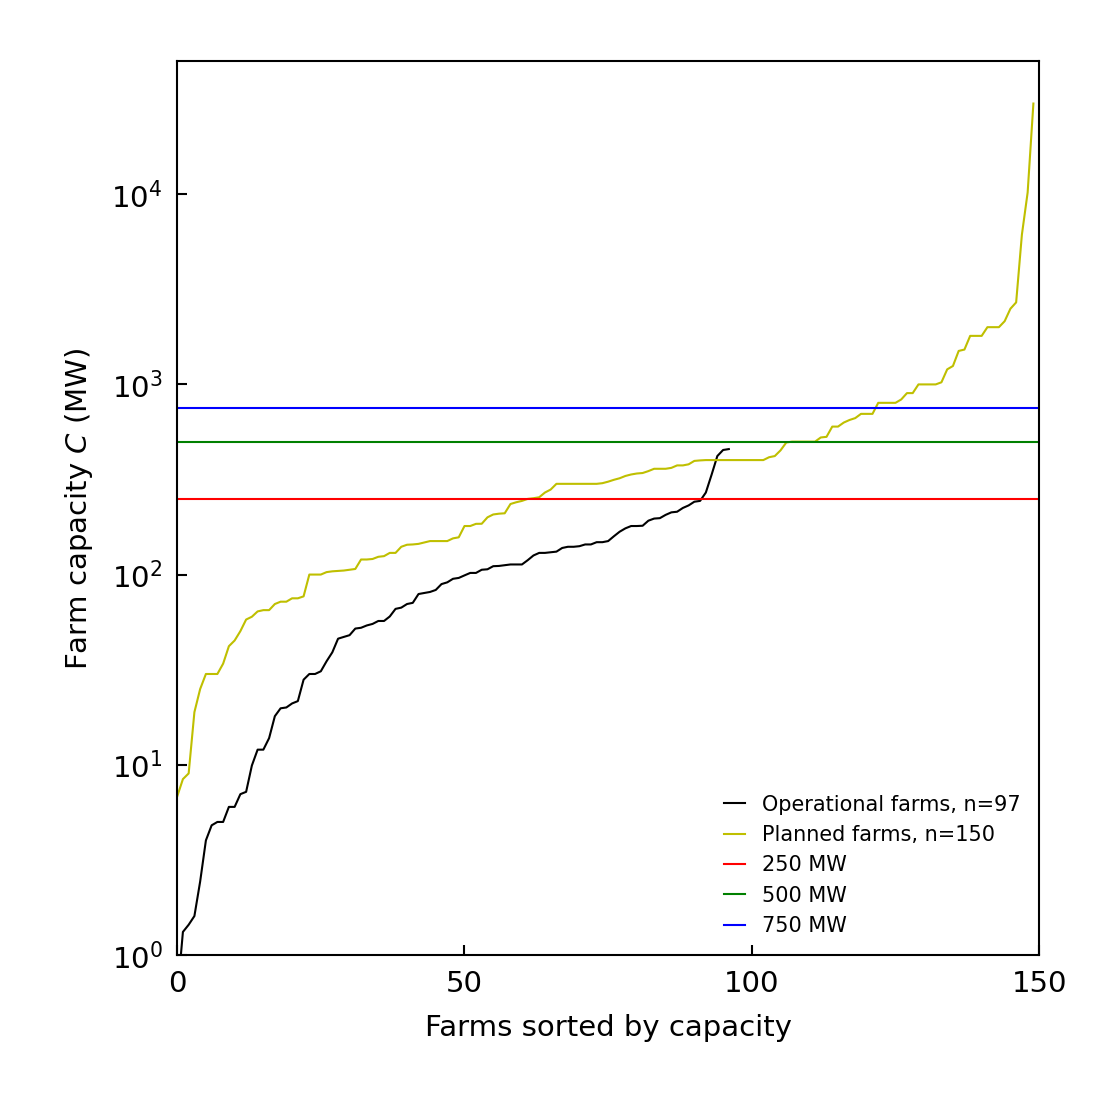

In [62]:
draft = False

cl = ['r','g','b']
lw = 0.5
ss = 2
fs = 7

figw = 89
figh = 89
buffw0 = 0
pltspan0w = 0.2
pltspan0h = pltspan0w/((lonlims[1]-lonlims[0])/(latlims[1]-latlims[0])/figw*figh)
labbuf = 0.01
latbuf = 3
pltspan1w = 0.82
pltspan1h = 0.85
buffh0 = 0.08
buffh1 = 0.12
pltspan2h = (pltspan1h-buffh1)/2
buffw1 = 0.08

ax5l,ax5b,ax5w,ax5h = 0.14,0.12,pltspan1w,pltspan1h

fig = plt.gcf()

ax00 = fig.add_axes([0,0,1,1])
ax00.patch.set_alpha(0)
ax00.set_zorder(1)
if draft:
    plt.xticks([])
    plt.yticks([])
else:
    plt.axis('off')

ax00.set_xlim(0,1)
ax00.set_ylim(0,1)

ax5 = fig.add_axes([ax5l,ax5b,ax5w,ax5h])
plt.plot(np.sort(farmcapacity)*1e-6,'k',lw=lw,label='Operational farms, n=%d'%len(farmcapacity))
plt.plot(np.sort(plannedfarmcapacity)*1e-6,'y',lw=lw,label='Planned farms, n=%d'%len(plannedfarmcapacity))
for k in range(len(hypthfarmcapacity)):
    plt.plot([0,len(plannedfarmcapacity)],[hypthfarmcapacity[k]*1e-6,hypthfarmcapacity[k]*1e-6],c=cl[k],lw=lw,label='%d MW'%(hypthfarmcapacity[k]*1e-6))
plt.yscale('log')
plt.xlim(0,len(plannedfarmcapacity))
plt.ylim(1e+0,5e+4)
plt.xticks([0,50,100,150],fontsize=7)
plt.yticks([1e+0,1e+1,1e+2,1e+3,1e+4],fontsize=7)
plt.xlabel('Farms sorted by capacity',fontsize=7)
plt.ylabel('Farm capacity $C$ (MW)',fontsize=7)
plt.legend(handlelength=lw*2,fontsize=5,frameon=False,loc=4)

for ax in fig.axes:
    ax.tick_params(width=lw,length=lw*5,which='both',direction='in')
    ax.minorticks_off()
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(lw)

fig.set_size_inches(figw/25.4,figh/25.4,forward=True)
if draft==False:
    plt.savefig(directory+'figures/figS1.pdf',dpi=300)
    plt.savefig(directory+'figures/figS1.png',dpi=300)

In [63]:
df = pd.read_csv(directory+'supply__wind_turbine_library.csv')

windspeed   = []
poweroutput = []
rotorarea   = []
turbinename = []

for i in range(len(df)):
    try:
        windspeed.append(np.asarray(literal_eval(df['power_curve_wind_speeds'][i])))
        poweroutput.append(np.asarray(literal_eval(df['power_curve_values'][i]))*1e+3)
        rotorarea.append(df['rotor_area'][i])
        turbinename.append(df['manufacturer'][i] + ' ' + df['name'][i])
        
    except:
        continue
        
cutinspeed  = []
cutoutspeed = []
maxpower = []

for i in range(len(windspeed)):
    maxpower.append(np.max(poweroutput[i]))
    if poweroutput[i][0]>0:
        cutinspeed.append(windspeed[i][0])
    else:
        cutinspeed.append(windspeed[i][np.min(np.argwhere(poweroutput[i]>0).flatten())])
    if poweroutput[i][-1]!=0:
        cutoutspeed.append(windspeed[i][-1])
    else:
        cutoutspeed.append(windspeed[i][np.max(np.argwhere(poweroutput[i]>0).flatten())])

wind = np.linspace(0,35,300)

powerinterp = np.zeros((len(windspeed),len(wind)))
for i in range(len(windspeed)):
    powerinterp[i][(wind>=cutinspeed[i])&(wind<=cutoutspeed[i])] = np.interp(wind[(wind>=cutinspeed[i])&(wind<=cutoutspeed[i])],
                              windspeed[i][(windspeed[i]>=cutinspeed[i])&(windspeed[i]<=cutoutspeed[i])],
                              poweroutput[i][(windspeed[i]>=cutinspeed[i])&(windspeed[i]<=cutoutspeed[i])])

/jobfs/95717059.gadi-pbs/ipykernel_1959009/234661634.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20')
/jobfs/95717059.gadi-pbs/ipykernel_1959009/234661634.py:52: RuntimeWarning: divide by zero encountered in power
  h2 = (f**-beta+g**-beta)**(-1/beta)


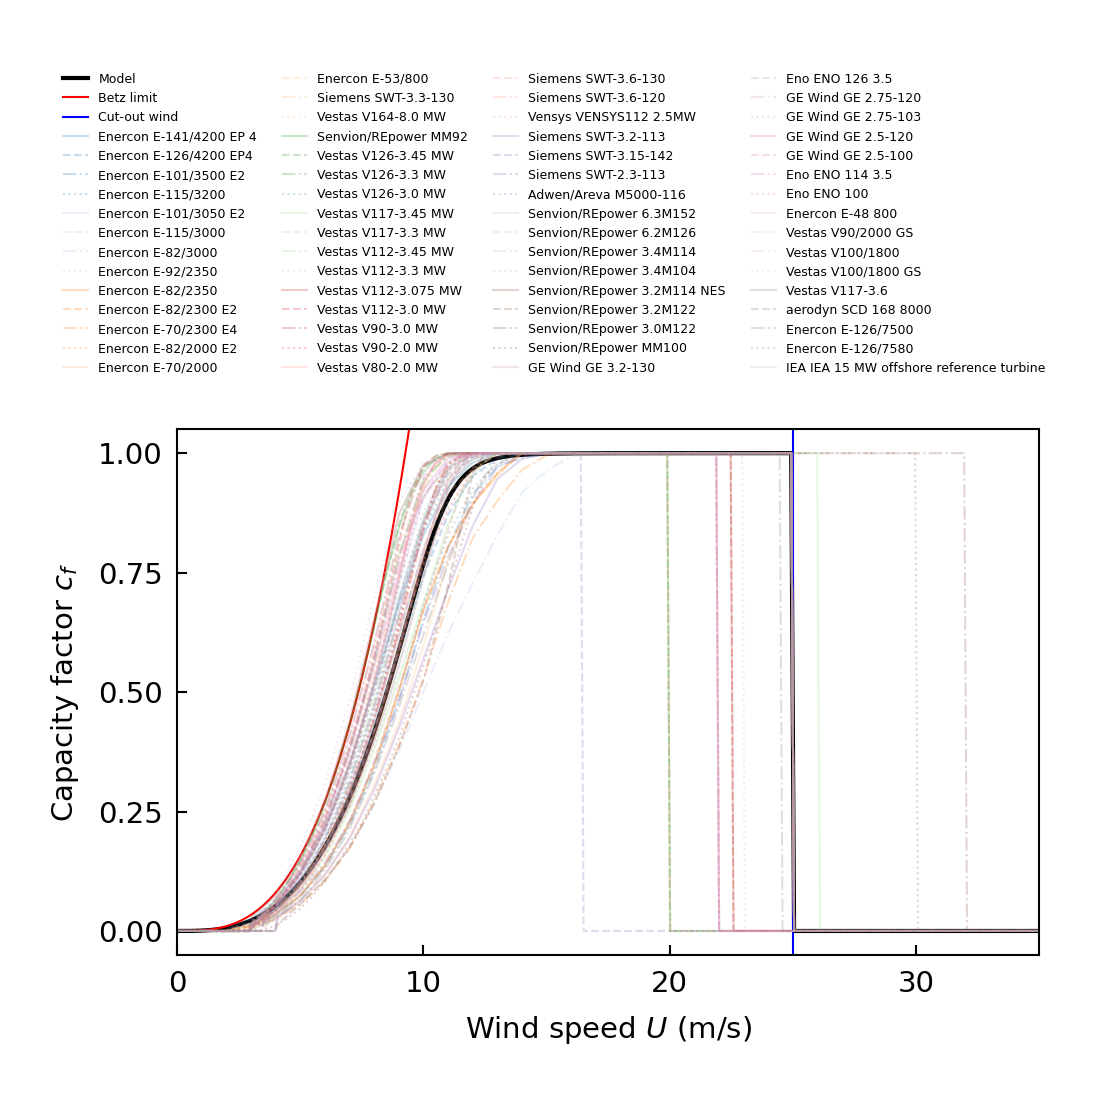

In [64]:
draft = False

cmap = cm.get_cmap('tab20')

ls = ['solid','dashed','dashdot','dotted']
alpha = 0.25
lw = 0.5
fs = 7

figw = 89
figh = 89
buffw0 = 0
labbuf = 0.01
latbuf = 3
pltspan1w = 0.82
pltspan1h = 0.5
buffh0 = 0.08
buffh1 = 0.12
pltspan2h = (pltspan1h-buffh1)/2
buffw1 = 0.08

ax5l,ax5b,ax5w,ax5h = 0.14,0.12,pltspan1w,pltspan1h

fig = plt.gcf()

ax00 = fig.add_axes([0,0,1,1])
ax00.patch.set_alpha(0)
ax00.set_zorder(1)
if draft:
    plt.xticks([])
    plt.yticks([])
else:
    plt.axis('off')

ax00.set_xlim(0,1)
ax00.set_ylim(0,1)

ax5 = fig.add_axes([ax5l,ax5b,ax5w,ax5h])

efficiencyX  = 0.65
rotorareaX   = 75**2*np.pi
maxpowerX    = 5e+6
cutoutspeedX = 25
cutinspeedX  = 0

rhof  = 1.2
betzC = 16/27
beta  = 5

f = efficiencyX*rotorareaX*rhof*betzC/2*wind**3
g = np.ones_like(wind)*maxpowerX
h2 = (f**-beta+g**-beta)**(-1/beta)
h2[wind>np.median(cutoutspeedX)] = 0
h2[wind<np.median(cutinspeedX)] = 0
plt.plot(wind,h2/maxpowerX,'k',lw=2*lw,zorder=-1,label='Model')
plt.plot(wind,rotorareaX*rhof*betzC/2*wind**3/maxpowerX,'r',lw=lw,label='Betz limit')
plt.plot([cutoutspeedX,cutoutspeedX],[-0.05,1.05],'b',lw=lw,label='Cut-out wind')

count = 0
for i in range(20):
    for j in range(4):
        if count<len(turbinename):
            plt.plot(wind,powerinterp[count]/maxpower[count],ls=ls[j],c=cmap(i/20),alpha=alpha,lw=lw,
                     label=turbinename[count])
        count += 1

plt.xlim(0,35)
plt.ylim(-0.05,1.05)
plt.xticks([0,10,20,30],fontsize=7)
plt.yticks([0,0.25,0.5,0.75,1],fontsize=7)
plt.xlabel('Wind speed $U$ (m/s)',fontsize=7)
plt.ylabel('Capacity factor $c_f$',fontsize=7)
plt.legend(fontsize=3,ncol=4,handlelength=2,frameon=False,loc='upper right',bbox_to_anchor=(1.02,1.7))

for ax in fig.axes:
    ax.tick_params(width=lw,length=lw*5,which='both',direction='in')
    ax.minorticks_off()
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(lw)

fig.set_size_inches(figw/25.4,figh/25.4,forward=True)
if draft==False:
    plt.savefig(directory+'figures/figS2.pdf',dpi=300)
    plt.savefig(directory+'figures/figS2.png',dpi=300)

/jobfs/95717059.gadi-pbs/ipykernel_1959009/2139290081.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10')


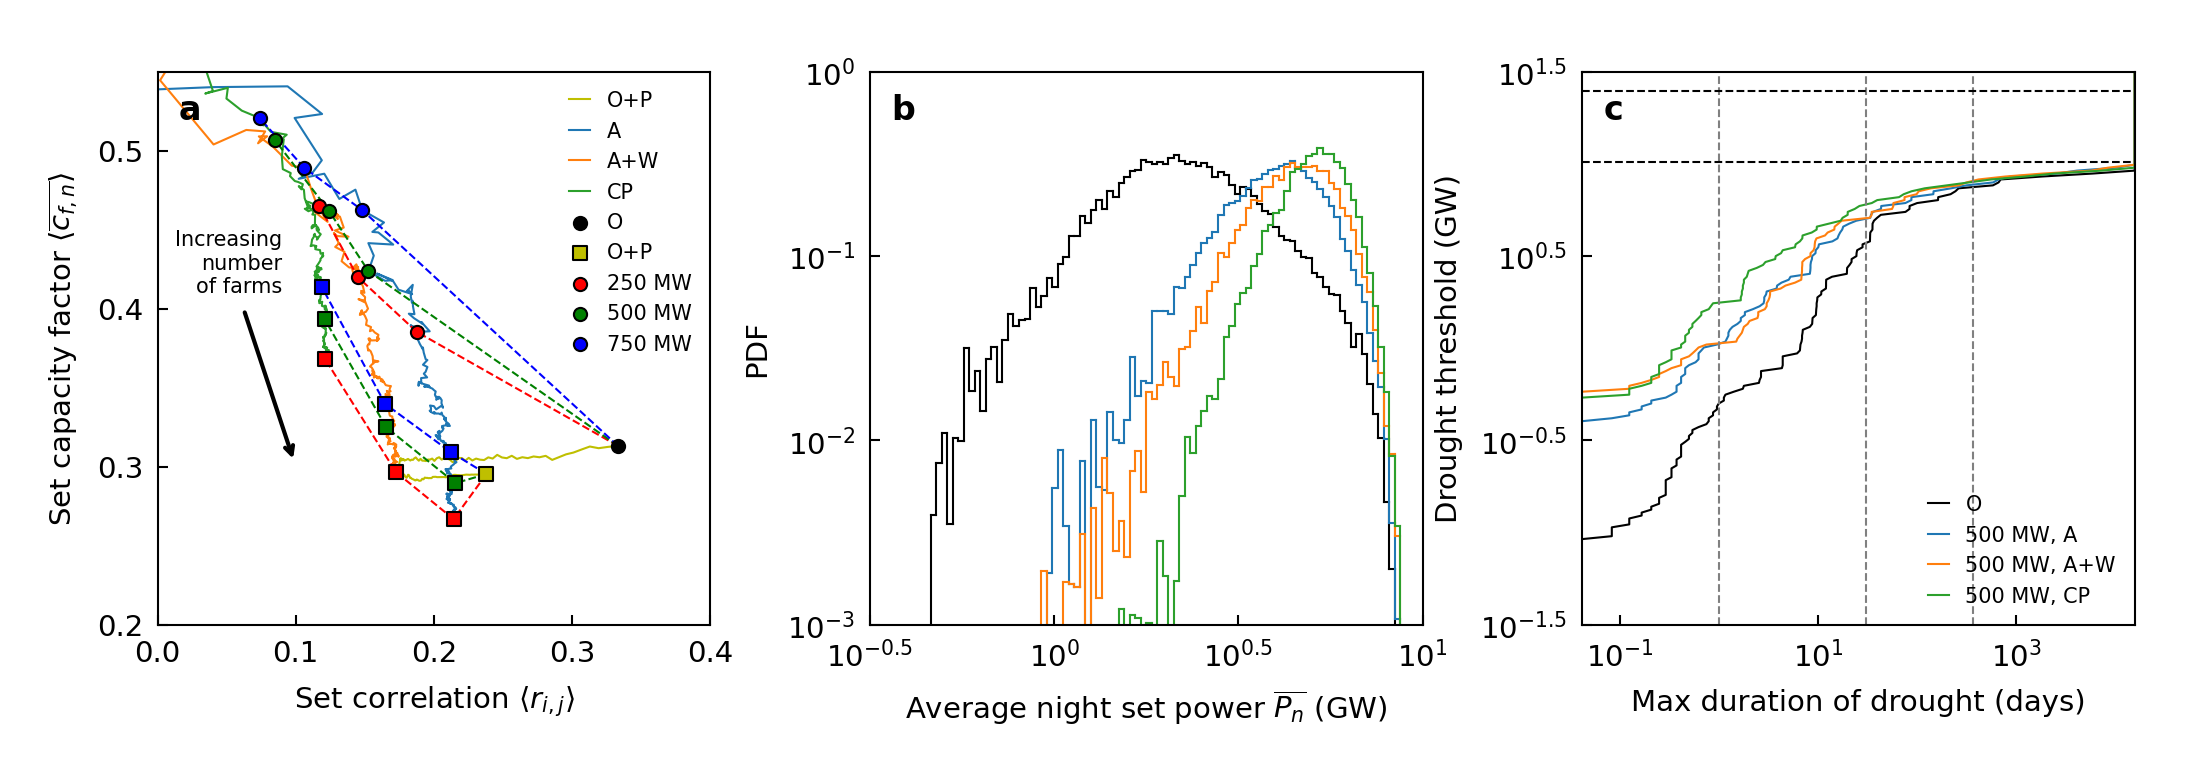

In [65]:
draft = False

cmap = plt.cm.get_cmap('tab10')

cl = ['r','g','b']
sXy = ['A','A+W','CP']
lw = 0.5
ss = 10
fs = 7

figw = 180
figh = 60
pltspan0w = 0.26
pltspan0h = pltspan0w/figh*figw
pltspan1w = 0.1
pltspan1h = pltspan1w/figh*figw
buffw0 = 0.075
buffw1 = 0.145
buffh1 = 0.44
buffw2 = 0.05
buffh2 = 0.13
labbuf = 0.01

ax0l,ax0b,ax0w,ax0h = 0.06,0.16,pltspan0w,pltspan0h
ax1l,ax1b,ax1w,ax1h = ax0l+1*(pltspan0w+buffw0),ax0b,pltspan0w,pltspan0h
ax3l,ax3b,ax3w,ax3h = ax0l+2*(pltspan0w+buffw0),ax0b,pltspan0w,pltspan0h

fig = plt.gcf()

ax00 = fig.add_axes([0,0,1,1])
ax00.patch.set_alpha(0)
ax00.set_zorder(1)
if draft:
    plt.xticks([])
    plt.yticks([])
else:
    plt.axis('off')

ax00.text(ax0l+labbuf,ax0b+ax0h-labbuf/figh*figw,'a',fontsize=8, weight='bold',va='top',ha='left')
ax00.text(ax1l+labbuf,ax1b+ax1h-labbuf/figh*figw,'b',fontsize=8, weight='bold',va='top',ha='left')
ax00.text(ax3l+labbuf,ax3b+ax3h-labbuf/figh*figw,'c',fontsize=8, weight='bold',va='top',ha='left')
ax00.set_xlim(0,1)
ax00.set_ylim(0,1)

ax0 = fig.add_axes([ax0l,ax0b,ax0w,ax0h])
plt.plot(ravgs2,cfnavgs2,lw=lw,zorder=-1,label='O+P',c='y')
plt.plot(ravgs3,cfnavgs3,lw=lw,zorder=-1,label='A')
plt.plot(ravgs4,cfnavgs4,lw=lw,zorder=-1,label='A+W')
plt.plot(ravgs5,cfnavgs5,lw=lw,zorder=-1,label='CP')
tempindss1 = [np.argwhere(ninds==nhypthfarms_s1[i])[0][0] for i in range(len(nhypthfarms_s1))]
tempindss2 = [np.argwhere(ninds==nhypthfarms_s2[i])[0][0] for i in range(len(nhypthfarms_s2))]
for k in range(len(tempindss1)):
    tempx = [ravgs2[0],ravgs3[tempindss1[k]],ravgs4[tempindss1[k]],ravgs5[tempindss1[k]]]
    tempy = [cfnavgs2[0],cfnavgs3[tempindss1[k]],cfnavgs4[tempindss1[k]],cfnavgs5[tempindss1[k]]]
    plt.plot(tempx,tempy,'--',color=cl[k],lw=lw,zorder=-1)
    tempx = [ravgs2[-1],ravgs3[tempindss2[k]],ravgs4[tempindss2[k]],ravgs5[tempindss2[k]]]
    tempy = [cfnavgs2[-1],cfnavgs3[tempindss2[k]],cfnavgs4[tempindss2[k]],cfnavgs5[tempindss2[k]]]
    plt.plot(tempx,tempy,'--',color=cl[k],lw=lw,zorder=-1)
for k in range(len(tempindss1)):
    plt.scatter(ravgs3[tempindss1[k]],cfnavgs3[tempindss1[k]],color=cl[k],lw=lw,s=ss,edgecolor='k')
    plt.scatter(ravgs4[tempindss1[k]],cfnavgs4[tempindss1[k]],color=cl[k],lw=lw,s=ss,edgecolor='k')
    plt.scatter(ravgs5[tempindss1[k]],cfnavgs5[tempindss1[k]],color=cl[k],lw=lw,s=ss,edgecolor='k')
    plt.scatter(ravgs3[tempindss2[k]],cfnavgs3[tempindss2[k]],color=cl[k],lw=lw,s=ss,edgecolor='k',marker='s')
    plt.scatter(ravgs4[tempindss2[k]],cfnavgs4[tempindss2[k]],color=cl[k],lw=lw,s=ss,edgecolor='k',marker='s')
    plt.scatter(ravgs5[tempindss2[k]],cfnavgs5[tempindss2[k]],color=cl[k],lw=lw,s=ss,edgecolor='k',marker='s')
plt.scatter(ravgs2[0],cfnavgs2[0],color='k',lw=lw,s=ss,edgecolor='k',label='O')
plt.scatter(ravgs2[-1],cfnavgs2[-1],color='y',lw=lw,s=ss,edgecolor='k',marker='s',label='O+P')
for k in range(len(tempindss1)):
    plt.scatter(np.nan,np.nan,color=cl[k],lw=lw,s=ss,edgecolor='k',label='%d MW'%(hypthfarmcapacity[k]*1e-6))
plt.annotate('Increasing\nnumber\nof farms', xy=(0.1,0.3),  xycoords='data',xytext=(0.09, 0.45), textcoords='data',arrowprops=dict(arrowstyle="->",connectionstyle="arc3"),horizontalalignment='right', verticalalignment='top',fontsize=5)
plt.xlim(0,0.4)
plt.ylim(0.2,0.55)
plt.xticks([0,0.1,0.2,0.3,0.4],fontsize=7)
plt.yticks([0.2,0.3,0.4,0.5],fontsize=7)
plt.xlabel('Set correlation $\\langle r_{i,j}\\rangle$',fontsize=7)
plt.ylabel('Set capacity factor $\\langle \\overline{c_{f,n}}\\rangle$',fontsize=7)
plt.legend(handlelength=lw*2,frameon=False,fontsize=5)

ax1 = fig.add_axes([ax1l,ax1b,ax1w,ax1h])
for i in range(len(countss1)):
    plt.plot([binss1[i],binss1[i+1]],[countss1[i],countss1[i]],c='k',lw=lw)
    if i==0:
        plt.plot([binss1[i],binss1[i]],[0,countss1[i]],c='k',lw=lw)
    else:
        plt.plot([binss1[i],binss1[i]],[countss1[i-1],countss1[i]],c='k',lw=lw)
plt.plot(np.nan,np.nan,c='k',lw=lw)
for j in range(np.shape(powersums)[1]):
    k = 1
    for i in range(len(countss1)):
        plt.plot([binss1[i],binss1[i+1]],[counts[0,j,k,i],counts[0,j,k,i]],c=cmap(j/10+0.05),lw=lw)
        if i==0:
            plt.plot([binss1[i],binss1[i]],[0,counts[0,j,k,i]],c=cmap(j/10+0.05),lw=lw)
        else:
            plt.plot([binss1[i],binss1[i]],[counts[0,j,k,i-1],counts[0,j,k,i]],c=cmap(j/10+0.05),lw=lw)
    plt.plot(np.nan,np.nan,c=cmap(j/10+0.05),lw=lw)
plt.xlim(binss1[0],binss1[-1])
plt.ylim(1e-3,1e-0)
plt.xscale('log')
plt.yscale('log')
plt.xticks([10**-0.5,1e+0,10**0.5,1e+1],['$10^{-0.5}$','$10^{0}$','$10^{0.5}$','$10^{1}$'],fontsize=7)
plt.yticks([1e-3,1e-2,1e-1,1e+0],fontsize=7)
plt.xlabel('Average night set power $\\overline{P_n}$ (GW)',fontsize=7)
plt.ylabel('PDF',fontsize=7)


ax3 = fig.add_axes([ax3l,ax3b,ax3w,ax3h])
plt.plot(droughts1/24,tempthr*1e-9,lw=lw,c='k',label='O')
for j in range(np.shape(powertimeseries)[1]):
    k = 1
    plt.plot(drought[0,j,k]/24,tempthr*1e-9,c=cmap(j/10+0.05),lw=lw,label='%d MW, %s'%(hypthfarmcapacity[k]*1e-6,sXy[j]))
plt.plot([1,1],[tempthr[0]*1e-9,tempthr[-1]*1e-9],'--',c='grey',lw=lw)
plt.plot([365/12,365/12],[tempthr[0]*1e-9,tempthr[-1]*1e-9],'--',c='grey',lw=lw)
plt.plot([365,365],[tempthr[0]*1e-9,tempthr[-1]*1e-9],'--',c='grey',lw=lw)
plt.plot([1/24,len(powertimeseriess2)/24],[25,25],'--k',lw=lw)
plt.plot([1/24,len(powertimeseriess2)/24],[(np.sum(farmcapacity))*1e-9,(np.sum(farmcapacity))*1e-9],'--k',lw=lw)
plt.xscale('log')
plt.yscale('log')
plt.xlim(1/24,len(powertimeseriess1)/24)
plt.ylim(10**-1.5,10**1.5)
plt.xticks([1e-1,1e+1,1e+3],fontsize=7)
plt.yticks([10**-1.5,10**-0.5,10**0.5,10**1.5],['$10^{-1.5}$','$10^{-0.5}$','$10^{0.5}$','$10^{1.5}$'],fontsize=7)
plt.xlabel('Max duration of drought (days)',fontsize=7)
plt.ylabel('Drought threshold (GW)',fontsize=7)
plt.legend(handlelength=lw*2,frameon=False,fontsize=5,loc=4)

for ax in fig.axes:
    ax.tick_params(width=lw,length=lw*5,which='both',direction='in')
    ax.minorticks_off()
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(lw)
        
fig.set_size_inches(figw/25.4,figh/25.4,forward=True)
if draft==False:
    plt.savefig(directory+'figures/figS3.pdf',dpi=300)
    plt.savefig(directory+'figures/figS3.png',dpi=300)

In [66]:
tempxc = np.mean(Wmaavg*coastm[None,...],0)
tempyc = np.mean(Wmnavg*coastm[None,...],0)/tempxc
tempzc = np.std(Wmaavg*coastm[None,...],0)/tempxc
tempuc = np.std(Wmnavg*coastm[None,...],0)/np.mean(Wmnavg*coastm[None,...],0)

tempxl = np.mean(Wmaavg*lsm[None,...],0)
tempyl = np.mean(Wmnavg*lsm[None,...],0)/tempxl
tempzl = np.std(Wmaavg*lsm[None,...],0)/tempxl
tempul = np.std(Wmnavg*lsm[None,...],0)/np.mean(Wmnavg*lsm[None,...],0)

/jobfs/95717059.gadi-pbs/ipykernel_1959009/1808318096.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('PiYG')


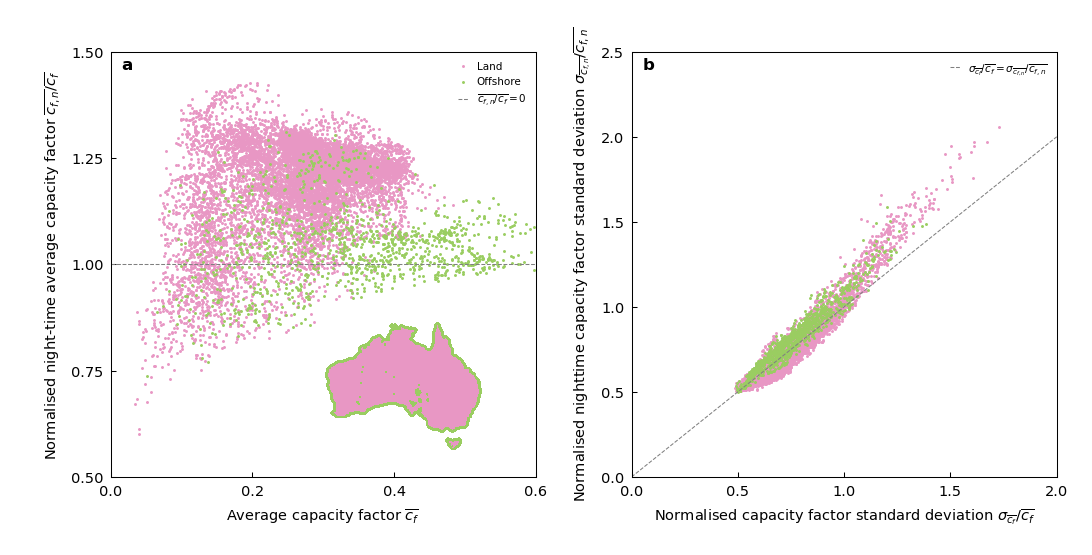

In [67]:
draft = False

cmap = plt.cm.get_cmap('PiYG')

lw = 0.5
ss = 2
fs = 7

figw = 180
figh = 89
buffw0 = 0.09
buffh0 = 0.12
pltspan0w = 0.4
pltspan0h = pltspan0w/figh*figw
pltspan1w = pltspan0w*0.4
pltspan1h = pltspan0h*0.4
buffw1 = 0.05
buffh1 = 0.4
pltspan2w = 0.15
pltspan2h = pltspan2w/((lonlims[1]-lonlims[0])/(latlims[1]-latlims[0])/figw*figh)
buffw2 = 0.2
buffh2 = 0.05

ax0l,ax0b,ax0w,ax0h = 0.0,0.0,pltspan0w,pltspan0h

labbuf = 0.01

ax0l,ax0b,ax0w,ax0h = buffw0,buffh0,pltspan0w,pltspan0h
ax1l,ax1b,ax1w,ax1h = ax0l+pltspan0w+buffw0,ax0b,pltspan0w,pltspan0h
ax3l,ax3b,ax3w,ax3h = ax0l+buffw2,ax0b+buffh2,pltspan2w,pltspan2h

fig = plt.gcf()
fig.set_dpi(150)

ax00 = fig.add_axes([0,0,1,1])
ax00.patch.set_alpha(0)
ax00.set_zorder(1)
if draft:
    plt.xticks([])
    plt.yticks([])
else:
    plt.axis('off')

ax00.text(ax0l+labbuf,ax0b+ax0h-labbuf,'a',fontsize=8, weight='bold',va='top',ha='left')
ax00.text(ax1l+labbuf,ax1b+ax1h-labbuf,'b',fontsize=8, weight='bold',va='top',ha='left')
ax00.set_xlim(0,1)
ax00.set_ylim(0,1)

ax0 = fig.add_axes([ax0l,ax0b,ax0w,ax0h])
plt.scatter(tempxl,tempyl,s=ss,lw=0,color=cmap(0.25),label='Land')
plt.scatter(tempxc,tempyc,s=ss,lw=0,color=cmap(0.75),label='Offshore')
plt.plot([0,0.6],[1,1],'--',c='grey',lw=lw,label='$\\overline{c_{f,n}}/\\overline{c_f}=0$')
plt.xlim(0,0.6)
plt.ylim(0.5,1.5)
plt.xticks([0,0.2,0.4,0.6],fontsize=7)
plt.yticks([0.5,0.75,1,1.25,1.5],fontsize=7)
plt.xlabel('Average capacity factor $\\overline{c_f}$',fontsize=7)
plt.ylabel('Normalised night-time average capacity factor $\\overline{c_{f,n}}/\\overline{c_f}$',fontsize=7)
plt.legend(handlelength=lw*2,frameon=False,fontsize=5)

ax3 = fig.add_axes([ax3l,ax3b,ax3w,ax3h])
p0 = plt.pcolor(lsmdf.longitude,lsmdf.latitude,lsm,cmap='PiYG',vmin=0,vmax=4,rasterized=True)
p0 = plt.pcolor(lsmdf.longitude,lsmdf.latitude,coastm+2,cmap='PiYG',vmin=0,vmax=4,rasterized=True)
plt.axis('off')

ax1 = fig.add_axes([ax1l,ax1b,ax1w,ax1h])
plt.scatter(tempzl,tempul,s=ss,lw=0,color=cmap(0.25))
plt.scatter(tempzc,tempuc,s=ss,lw=0,color=cmap(0.75))
plt.plot([0,2],[0,2],'--',c='grey',lw=lw,label='$\\sigma_{\\overline{c_f}}/\\overline{c_f}=\\sigma_{\\overline{c_{f,n}}}/\\overline{c_{f,n}}$')
plt.xlim(0,2)
plt.ylim(0,2.5)
plt.xticks([0,0.5,1,1.5,2],fontsize=7)
plt.yticks([0,0.5,1,1.5,2,2.5],fontsize=7)
plt.xlabel('Normalised capacity factor standard deviation $\\sigma_{\\overline{c_f}}/\\overline{c_f}$',fontsize=7)
plt.ylabel('Normalised nighttime capacity factor standard deviation $\\sigma_{\\overline{c_{f,n}}}/\\overline{c_{f,n}}$',fontsize=7)
plt.legend(handlelength=lw*2,frameon=False,fontsize=5)

for ax in fig.axes:
    ax.tick_params(width=lw,length=lw*5,which='both',direction='in')
    ax.minorticks_off()
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(lw)

fig.set_size_inches(figw/25.4,figh/25.4,forward=True)
if draft==False:
    plt.savefig(directory+'figures/figS4.pdf',dpi=300)
    plt.savefig(directory+'figures/figS4.png',dpi=300)

In [82]:
pdist   = pairwise_distances(rlsmcs5Wmnavg)
nindsmethods   = np.round(np.logspace(np.log10(2),np.log10(200),10)).astype(int)
methods = ['complete','average','weighted','centroid','ward']

idxmap = np.empty((len(methods),np.shape(lsmc)[0],np.shape(lsmc)[1]))*np.nan
tempflat = np.empty((len(methods),len(nindsmethods),np.max(nindsmethods)))*np.nan

for j in range(len(methods)):
    linkage = sch.linkage(squareform(pdist.astype('float32')), method=methods[j])
    for k in range(len(nindsmethods)):
        idx     = sch.fcluster(linkage, nindsmethods[k], 'maxclust')
        try:
            tempflat[j,k,:nindsmethods[k]] = [np.argwhere(idx==i)[np.argmax(np.mean(Wmnavglsmcflat,0)[idx==i])][0] for i in range(1,nindsmethods[k]+1)]
        except:
            continue
        if nindsmethods[k]==15:
            inds          = np.ndarray.flatten(np.argwhere(np.ndarray.flatten(lsmc)==1))
            tidxmap       = np.empty((np.shape(lsmc)[0]*np.shape(lsmc)[1]))*np.nan
            tidxmap[inds] = idx
            idxmap[j]     = tidxmap.reshape(np.shape(lsmc)[0],np.shape(lsmc)[1])
        print(j,k,end='\r')
    

/jobfs/95717059.gadi-pbs/ipykernel_1959009/3392608700.py:5: RuntimeWarning: invalid value encountered in multiply
  idxmap = np.empty((len(methods),np.shape(lsmc)[0],np.shape(lsmc)[1]))*np.nan


In [83]:
tempavgcf = np.empty((len(methods),len(nindsmethods)))
tempstdcf = np.empty((len(methods),len(nindsmethods)))
for j in range(len(methods)):
    for k in range(len(nindsmethods)):
        if (j==np.argwhere(np.nansum(tempflat/tempflat,axis=2)==0)[0][0])&(k==np.argwhere(np.nansum(tempflat/tempflat,axis=2)==0)[0][1]):
            tempavgcf[j,k] = np.nan
            tempstdcf[j,k] = np.nan  
        else:
            tempavgcf[j,k] = np.mean(Wmnavglsmcs5flat[:,tempflat[j,k,:nindsmethods[k]].astype(int)])
            tempstdcf[j,k] = np.std(np.mean(Wmnavglsmcs5flat[:,tempflat[j,k,:nindsmethods[k]].astype(int)],1))

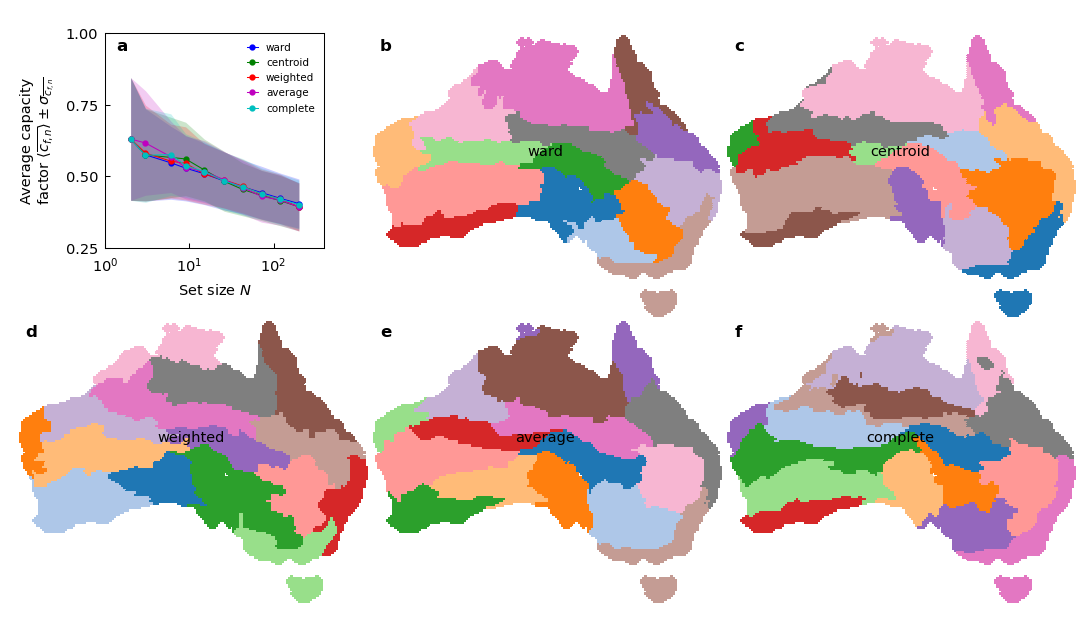

In [84]:
draft = False

lw = 0.5
ss = 2
fs = 7

cmap = ['c','m','r','g','b']

figw = 180
figh = 100
labbuf = 0.01
latbuf = 3
pltspan0w = 1/3
pltspan0h = pltspan0w/((lonlims[1]-lonlims[0])/(latlims[1]-latlims[0])/figw*figh)
buffw0 = 0.085
buffh0 = 0.12

ax0l,ax0b,ax0w,ax0h = 0,0,pltspan0w,pltspan0h
ax1l,ax1b,ax1w,ax1h = ax0l+pltspan0w,ax0b,pltspan0w,pltspan0h
ax2l,ax2b,ax2w,ax2h = ax0l+2*pltspan0w,ax0b,pltspan0w,pltspan0h
ax3l,ax3b,ax3w,ax3h = buffw0,ax0h+buffh0,pltspan0w-buffw0*1.5,pltspan0h-buffh0
ax4l,ax4b,ax4w,ax4h = ax0l+pltspan0w,pltspan0h,pltspan0w,pltspan0h
ax5l,ax5b,ax5w,ax5h = ax0l+2*pltspan0w,ax4b,pltspan0w,pltspan0h

fig = plt.gcf()
fig.set_dpi(150)

ax00 = fig.add_axes([0,0,1,1])
ax00.patch.set_alpha(0)
ax00.set_zorder(1)
if draft:
    plt.xticks([])
    plt.yticks([])
else:
    plt.axis('off')

ax00.text(ax0l+labbuf,ax0b+ax0h-labbuf,'d',fontsize=8, weight='bold',va='top',ha='left')
ax00.text(ax1l+labbuf,ax1b+ax1h-labbuf,'e',fontsize=8, weight='bold',va='top',ha='left')
ax00.text(ax2l+labbuf,ax2b+ax2h-labbuf,'f',fontsize=8, weight='bold',va='top',ha='left')
ax00.text(ax3l+labbuf,ax3b+ax3h-labbuf,'a',fontsize=8, weight='bold',va='top',ha='left')
ax00.text(ax4l+labbuf,ax4b+ax4h-labbuf,'b',fontsize=8, weight='bold',va='top',ha='left')
ax00.text(ax5l+labbuf,ax5b+ax5h-labbuf,'c',fontsize=8, weight='bold',va='top',ha='left')
ax00.set_xlim(0,1)
ax00.set_ylim(0,1)

ax0 = fig.add_axes([ax0l,ax0b,ax0w,ax0h])
j = 2
p0 = plt.pcolor(lsmdf.longitude,lsmdf.latitude,idxmap[j],cmap='tab20',vmin=0.5,vmax=20.5,rasterized=True)
plt.axis('off')
plt.text(np.mean(lonlims),np.mean(latlims)+latbuf,methods[j],fontsize=7,va='center',ha='center')
ax1 = fig.add_axes([ax1l,ax1b,ax1w,ax1h])
j = 1
p0 = plt.pcolor(lsmdf.longitude,lsmdf.latitude,idxmap[j],cmap='tab20',vmin=0.5,vmax=20.5,rasterized=True)
plt.axis('off')
plt.text(np.mean(lonlims),np.mean(latlims)+latbuf,methods[j],fontsize=7,va='center',ha='center')
ax2 = fig.add_axes([ax2l,ax2b,ax2w,ax2h])
j = 0
p0 = plt.pcolor(lsmdf.longitude,lsmdf.latitude,idxmap[j],cmap='tab20',vmin=0.5,vmax=20.5,rasterized=True)
plt.axis('off')
plt.text(np.mean(lonlims),np.mean(latlims)+latbuf,methods[j],fontsize=7,va='center',ha='center')
ax4 = fig.add_axes([ax4l,ax4b,ax4w,ax4h])
j = 4
p0 = plt.pcolor(lsmdf.longitude,lsmdf.latitude,idxmap[j],cmap='tab20',vmin=0.5,vmax=20.5,rasterized=True)
plt.axis('off')
plt.text(np.mean(lonlims),np.mean(latlims)+latbuf,methods[j],fontsize=7,va='center',ha='center')
ax5 = fig.add_axes([ax5l,ax5b,ax5w,ax5h])
j = 3
p0 = plt.pcolor(lsmdf.longitude,lsmdf.latitude,idxmap[j],cmap='tab20',vmin=0.5,vmax=20.5,rasterized=True)
plt.axis('off')
plt.text(np.mean(lonlims),np.mean(latlims)+latbuf,methods[j],fontsize=7,va='center',ha='center')

ax3 = fig.add_axes([ax3l,ax3b,ax3w,ax3h])
for j in np.flip(np.arange(len(methods))):
    plt.fill_between(nindsmethods[~np.isnan(tempavgcf[j])],
                     tempavgcf[j][~np.isnan(tempavgcf[j])]-tempstdcf[j][~np.isnan(tempavgcf[j])],
                     tempavgcf[j][~np.isnan(tempavgcf[j])]+tempstdcf[j][~np.isnan(tempavgcf[j])],alpha=0.2,lw=0,color=cmap[j])
    plt.plot(nindsmethods[~np.isnan(tempavgcf[j])],tempavgcf[j][~np.isnan(tempavgcf[j])],'-o',lw=lw,c=cmap[j],ms=ss,label=methods[j])
plt.xscale('log')
plt.xlim(1,400)
plt.ylim(0.25,1)
plt.xticks([1,10,100],fontsize=7)
plt.yticks([0.25,0.5,0.75,1],fontsize=7)
plt.xlabel('Set size $N$',fontsize=7)
plt.ylabel('Average capacity\nfactor $\\langle\\overline{c_{f,n}}\\rangle\\pm\\sigma_{\\overline{c_{f,n}}}$',fontsize=7)
plt.legend(handlelength=lw*2,frameon=False,fontsize=5)

for ax in fig.axes:
    ax.tick_params(width=lw,length=lw*5,which='both',direction='in')
    ax.minorticks_off()
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(lw)

fig.set_size_inches(figw/25.4,figh/25.4,forward=True)
if draft==False:
    plt.savefig(directory+'figures/figS5.pdf',dpi=300)
    plt.savefig(directory+'figures/figS5.png',dpi=300)

In [85]:
ninds0  = 15

pdist     = pairwise_distances(rlsmcs3Wmnavg)
linkages3 = sch.linkage(squareform(pdist.astype('float32')), method='complete')
idx       = sch.fcluster(linkages3, ninds0, 'maxclust')
idxmap    = np.empty((np.shape(lsmc)[0]*np.shape(lsmc)[1]))*np.nan
inds      = np.ndarray.flatten(np.argwhere(np.ndarray.flatten(lsmcs3)==1))
idxmap[inds] = idx
idxmaps3     = idxmap.reshape(np.shape(lsmc)[0],np.shape(lsmc)[1])

pdist     = pairwise_distances(rlsmcs4Wmnavg)
linkages4 = sch.linkage(squareform(pdist.astype('float32')), method='complete')
idx       = sch.fcluster(linkages4, ninds0, 'maxclust')
idxmap    = np.empty((np.shape(lsmc)[0]*np.shape(lsmc)[1]))*np.nan
inds      = np.ndarray.flatten(np.argwhere(np.ndarray.flatten(lsmcs4)==1))
idxmap[inds] = idx
idxmaps4     = idxmap.reshape(np.shape(lsmc)[0],np.shape(lsmc)[1])

pdist     = pairwise_distances(rlsmcs5Wmnavg)
linkages5 = sch.linkage(squareform(pdist.astype('float32')), method='complete')
idx       = sch.fcluster(linkages5, ninds0, 'maxclust')
idxmap    = np.empty((np.shape(lsmc)[0]*np.shape(lsmc)[1]))*np.nan
inds      = np.ndarray.flatten(np.argwhere(np.ndarray.flatten(lsmc)==1))
idxmap[inds] = idx
idxmaps5     = idxmap.reshape(np.shape(lsmc)[0],np.shape(lsmc)[1])

/jobfs/95717059.gadi-pbs/ipykernel_1959009/395067044.py:44: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10')
/jobfs/95717059.gadi-pbs/ipykernel_1959009/395067044.py:75: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20')


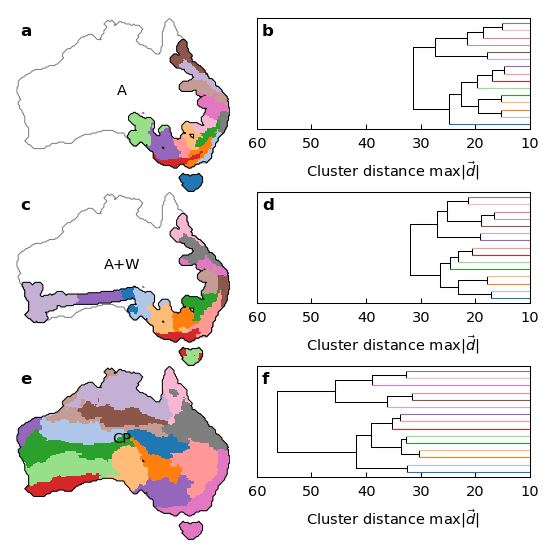

In [86]:
draft = False

lw = 0.5
ss = 2
fs = 7

figw = 89
figh = 89
buffw0 = 0.05
buffw1 = 0.02
pltspan0w = 0.41
pltspan0h = pltspan0w/((lonlims[1]-lonlims[0])/(latlims[1]-latlims[0])/figw*figh)
buffh0 = 0.12
labbuf = 0.01

ax0l,ax0b,ax0w,ax0h = 0.0,0.0,pltspan0w,pltspan0h
ax1l,ax1b,ax1w,ax1h = ax0l,ax0b+ax0h,pltspan0w,pltspan0h
ax2l,ax2b,ax2w,ax2h = ax0l,ax0b+2*pltspan0h,pltspan0w,pltspan0h
ax3l,ax3b,ax3w,ax3h = ax0l+pltspan0w+buffw0,ax0b+buffh0,1-pltspan0w-buffw0-buffw1,pltspan0h-buffh0
ax4l,ax4b,ax4w,ax4h = ax1l+pltspan0w+buffw0,ax1b+buffh0,1-pltspan0w-buffw0-buffw1,pltspan0h-buffh0
ax5l,ax5b,ax5w,ax5h = ax2l+pltspan0w+buffw0,ax2b+buffh0,1-pltspan0w-buffw0-buffw1,pltspan0h-buffh0

fig = plt.gcf()
fig.set_dpi(150)

ax00 = fig.add_axes([0,0,1,1])
ax00.patch.set_alpha(0)
ax00.set_zorder(1)
if draft:
    plt.xticks([])
    plt.yticks([])
else:
    plt.axis('off')

ax00.text(ax0l+labbuf,ax0b+ax0h-labbuf,'e',fontsize=8, weight='bold',va='top',ha='left')
ax00.text(ax1l+labbuf,ax1b+ax1h-labbuf,'c',fontsize=8, weight='bold',va='top',ha='left')
ax00.text(ax2l+labbuf,ax2b+ax2h-labbuf,'a',fontsize=8, weight='bold',va='top',ha='left')
ax00.text(ax3l+labbuf,ax3b+ax3h-labbuf,'f',fontsize=8, weight='bold',va='top',ha='left')
ax00.text(ax4l+labbuf,ax4b+ax4h-labbuf,'d',fontsize=8, weight='bold',va='top',ha='left')
ax00.text(ax5l+labbuf,ax5b+ax5h-labbuf,'b',fontsize=8, weight='bold',va='top',ha='left')
ax00.set_xlim(0,1)
ax00.set_ylim(0,1)

cmap = plt.cm.get_cmap('tab10')
ax0 = fig.add_axes([ax0l,ax0b,ax0w,ax0h])
p0 = plt.pcolor(lsmdf.longitude,lsmdf.latitude,idxmaps5,cmap='tab20',vmin=0.5,vmax=20.5,rasterized=True)
temp = np.copy(lsmc)
temp[np.isnan(temp)] = 0
plt.contour(lsmdf.longitude,lsmdf.latitude,temp,levels=[0.01],colors=['k'],linewidths=[lw])
plt.text(np.mean(lonlims),np.mean(latlims)+latbuf,'CP',fontsize=7,va='center',ha='center')
plt.axis('off')

ax1 = fig.add_axes([ax1l,ax1b,ax1w,ax1h])
p0 = plt.pcolor(lsmdf.longitude,lsmdf.latitude,idxmaps4,cmap='tab20',vmin=0.5,vmax=20.5,rasterized=True)
temp = np.copy(lsmc)
temp[np.isnan(temp)] = 0
plt.contour(lsmdf.longitude,lsmdf.latitude,temp,levels=[0.01],colors=['grey'],linewidths=[lw])
temp = np.copy(lsmcs4)
temp[np.isnan(temp)] = 0
plt.contour(lsmdf.longitude,lsmdf.latitude,temp,levels=[0.01],colors=['k'],linewidths=[lw])
plt.text(np.mean(lonlims),np.mean(latlims)+latbuf,'A+W',fontsize=7,va='center',ha='center')
plt.axis('off')

ax2 = fig.add_axes([ax2l,ax2b,ax2w,ax2h])
p0 = plt.pcolor(lsmdf.longitude,lsmdf.latitude,idxmaps3,cmap='tab20',vmin=0.5,vmax=20.5,rasterized=True)
temp = np.copy(lsmc)
temp[np.isnan(temp)] = 0
plt.contour(lsmdf.longitude,lsmdf.latitude,temp,levels=[0.01],colors=['grey'],linewidths=[lw])
temp = np.copy(lsmcs3)
temp[np.isnan(temp)] = 0
plt.contour(lsmdf.longitude,lsmdf.latitude,temp,levels=[0.01],colors=['k'],linewidths=[lw])
plt.text(np.mean(lonlims),np.mean(latlims)+latbuf,'A',fontsize=7,va='center',ha='center')
plt.axis('off')

cmap = plt.cm.get_cmap('tab20')
ax3 = fig.add_axes([ax3l,ax3b,ax3w,ax3h])
d0 = sch.dendrogram(linkages5,p=ninds0,truncate_mode='lastp',no_plot=True)
tempinds0 = np.argwhere(np.asarray(d0['dcoord'])==0.0)
tempinds1 = np.argsort([d0['icoord'][tempinds0[i][0]][tempinds0[i][1]] for i in range(len(tempinds0))])
for i in range(len(d0['icoord'])):
    plt.plot(d0['dcoord'][i],d0['icoord'][i],c='k',lw=lw)
for i in range(ninds0):
    if tempinds0[tempinds1[i]][1]==0:
        plt.plot(d0['dcoord'][tempinds0[tempinds1[i]][0]][0:2],
                 d0['icoord'][tempinds0[tempinds1[i]][0]][0:2],
                 c=cmap((i+0.5)/20),lw=lw)
    elif tempinds0[tempinds1[i]][1]==3:
        plt.plot(d0['dcoord'][tempinds0[tempinds1[i]][0]][2:4],
                 d0['icoord'][tempinds0[tempinds1[i]][0]][2:4],
                 c=cmap((i+0.5)/20),lw=lw)
plt.xlim(60,10)
plt.xticks([10,20,30,40,50,60],fontsize=7)
plt.yticks([])
plt.xlabel('Cluster distance $\\max{|\\vec{d}|}$',fontsize=7)

ax4 = fig.add_axes([ax4l,ax4b,ax4w,ax4h])
d0 = sch.dendrogram(linkages4,p=ninds0,truncate_mode='lastp',no_plot=True)
tempinds0 = np.argwhere(np.asarray(d0['dcoord'])==0.0)
tempinds1 = np.argsort([d0['icoord'][tempinds0[i][0]][tempinds0[i][1]] for i in range(len(tempinds0))])
for i in range(len(d0['icoord'])):
    plt.plot(d0['dcoord'][i],d0['icoord'][i],c='k',lw=lw)
for i in range(ninds0):
    if tempinds0[tempinds1[i]][1]==0:
        plt.plot(d0['dcoord'][tempinds0[tempinds1[i]][0]][0:2],
                 d0['icoord'][tempinds0[tempinds1[i]][0]][0:2],
                 c=cmap((i+0.5)/20),lw=lw)
    elif tempinds0[tempinds1[i]][1]==3:
        plt.plot(d0['dcoord'][tempinds0[tempinds1[i]][0]][2:4],
                 d0['icoord'][tempinds0[tempinds1[i]][0]][2:4],
                 c=cmap((i+0.5)/20),lw=lw)
plt.xlim(60,10)
plt.xticks([10,20,30,40,50,60],fontsize=7)
plt.yticks([])
plt.xlabel('Cluster distance $\\max{|\\vec{d}|}$',fontsize=7)

ax5 = fig.add_axes([ax5l,ax5b,ax5w,ax5h])
d0 = sch.dendrogram(linkages3,p=ninds0,truncate_mode='lastp',no_plot=True)
tempinds0 = np.argwhere(np.asarray(d0['dcoord'])==0.0)
tempinds1 = np.argsort([d0['icoord'][tempinds0[i][0]][tempinds0[i][1]] for i in range(len(tempinds0))])
for i in range(len(d0['icoord'])):
    plt.plot(d0['dcoord'][i],d0['icoord'][i],c='k',lw=lw)
for i in range(ninds0):
    if tempinds0[tempinds1[i]][1]==0:
        plt.plot(d0['dcoord'][tempinds0[tempinds1[i]][0]][0:2],
                 d0['icoord'][tempinds0[tempinds1[i]][0]][0:2],
                 c=cmap((i+0.5)/20),lw=lw)
    elif tempinds0[tempinds1[i]][1]==3:
        plt.plot(d0['dcoord'][tempinds0[tempinds1[i]][0]][2:4],
                 d0['icoord'][tempinds0[tempinds1[i]][0]][2:4],
                 c=cmap((i+0.5)/20),lw=lw)
plt.xlim(60,10)
plt.xticks([10,20,30,40,50,60],fontsize=7)
plt.yticks([])
plt.xlabel('Cluster distance $\\max{|\\vec{d}|}$',fontsize=7)

for ax in fig.axes:
    ax.tick_params(width=lw,length=lw*5,which='both',direction='in')
    ax.minorticks_off()
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(lw)

fig.set_size_inches(figw/25.4,figh/25.4,forward=True)
if draft==False:
    plt.savefig(directory+'figures/figS6.pdf',dpi=300)
    plt.savefig(directory+'figures/figS6.png',dpi=300)